# Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

In [395]:
#Data Structures
import pandas as pd
import numpy as np

#Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [396]:
df_train = pd.read_csv("telecom-churn-case-study-hackathon-c-63/train.csv")
df_train.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


### Data Understanding

In [397]:
df_train.shape

(69999, 172)

In [398]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [399]:
df_train.dtypes

id                     int64
circle_id              int64
loc_og_t2o_mou       float64
std_og_t2o_mou       float64
loc_ic_t2o_mou       float64
                      ...   
aon                    int64
aug_vbc_3g           float64
jul_vbc_3g           float64
jun_vbc_3g           float64
churn_probability      int64
Length: 172, dtype: object

## Data Preprocessing

### Check Missing Values

In [400]:
df_train.isna().sum()

id                     0
circle_id              0
loc_og_t2o_mou       702
std_og_t2o_mou       702
loc_ic_t2o_mou       702
                    ... 
aon                    0
aug_vbc_3g             0
jul_vbc_3g             0
jun_vbc_3g             0
churn_probability      0
Length: 172, dtype: int64

In [401]:
# Get columns which have missing values
missing_cols = df_train.columns[df_train.isnull().any()]
print(missing_cols)

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_7', 'last_date_of_month_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       ...
       'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6',
       'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8'],
      dtype='object', length=125)


In [402]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((df_train.isnull().sum()/len(df_train.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
arpu_3g_6,74.9
count_rech_2g_6,74.9
night_pck_user_6,74.9
arpu_2g_6,74.9
date_of_last_rech_data_6,74.9
...,...
last_day_rch_amt_8,0.0
vol_2g_mb_6,0.0
vol_2g_mb_7,0.0
vol_2g_mb_8,0.0


Observations : For most of the columns more then 74% values are missing.

In [403]:
def get_null_counts_map(df, cols):
    null_counts_map = {}
    for col in cols:
        null_counts_map[col] = df[col].isnull().sum()
    return null_counts_map

In [404]:
def get_filtered_columns_by_regex(df, regstr):
    return df.filter(regex=regstr).columns

In [405]:
def filter_columns_by_regex(df, regstr):
    filtered_columns = df.columns[df.columns.str.contains(regstr,regex=True)]
    print(filtered_columns.tolist())
    return filtered_columns

In [406]:
def show_na_percentage(df):
    print(100*df.isnull().mean().sort_values(ascending=False))

In [407]:
def get_percentage_na_columns_by_threshold(df, threshold):
    # making list of columns that have high missing values that we want to remove
    rmcols=[]
    na_cols_dict_percentage = dict()
    for i in df.columns:
        col_missing_val = df[i].isnull().mean()*100
        if(col_missing_val>=threshold):
            na_cols_dict_percentage[i] = col_missing_val
            rmcols.append(i)
    print("columns missing value percentage: ", na_cols_dict_percentage)
    return rmcols

In [408]:
#Replacing the NAN values with 0, considering there were no recharges done by the customer.
def impute_null_columns(df, cols):
    if cols is None:
        df=df.replace(np.nan,0)
    else:
        for col in cols:
            df[col] = df[col].replace(np.NaN,0.0)
    return df

In [409]:
#let's adding new column total recharge amount for data: total_rech_amt_data for calculating High Value customer process
def add_total_rech_amt_data(df):
    rc_col_map = {
        "6": ["av_rech_amt_data_6","total_rech_data_6"],
        "7": ["av_rech_amt_data_7","total_rech_data_7"],
        "8": ["av_rech_amt_data_8","total_rech_data_8"]
    }
    for i, rc_cols in rc_col_map.items():
        df["total_rech_amt_data_" + i] = df[rc_cols[0]] + df[rc_cols[1]]
    return df

In [410]:
def add_avg_rech_amt_good_phase(df, rc_cols):
    value = 0
    for rc in rc_cols:
        value += df[rc]
    df['total_avg_rech_amnt_6_7_GPhase'] = value/2
    return df


In [411]:
def drop_cols(df,cols):
    df.drop(cols,axis=1,inplace=True)
    if not isinstance(cols, list):
        print("Dropped columns: ", cols.to_list())
    else:
        print("Dropped columns: ", cols)

In [412]:
recharge_columns = filter_columns_by_regex(df_train, 'total_rech_data_|av_rech_amt_data_')

['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']


In [413]:
df_train = impute_null_columns(df_train,recharge_columns)

In [414]:
df_train = add_total_rech_amt_data(df_train)

In [415]:
#Defining total average recharge amount for good phase for months 6 and 7 (the good phase)
rc_cols = ["total_rech_amt_6", "total_rech_amt_7", "total_rech_amt_data_6", "total_rech_amt_data_7"]
df_train = add_avg_rech_amt_good_phase(df_train, rc_cols)

In [416]:
def create_quantile_filter_by_threshold(df, col, threshold):
    return df[col].quantile(threshold)

In [417]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = create_quantile_filter_by_threshold(df_train, "total_avg_rech_amnt_6_7_GPhase", 0.7)
print('70 percentile of 6th and 7th months avg recharge amount: '+str(high_value_filter),"\n")

telecom_df_high_val_cust = df_train[df_train.total_avg_rech_amnt_6_7_GPhase > high_value_filter]
print('Dataframe Shape after Filtering High Value Customers: ' + str(telecom_df_high_val_cust.shape),"\n")

70 percentile of 6th and 7th months avg recharge amount: 432.5 

Dataframe Shape after Filtering High Value Customers: (20984, 176) 



#### Tag churners and remove attributes of the churn phase

<ol>
<li> Now tagging the churned customers (churn = 1, else 0) based on the fourth month as follows: <br>Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.
<li> The attributes we need to use to tag churners are:
<ol>
<li>total_ic_mou_8
<li>total_og_mou_8
<li>vol_2g_mb_8
<li>vol_3g_mb_8
</ol>
<li>After tagging churners, we will remove all the attributes corresponding to the churn phase (all attributes having ‘ _8’, etc. in their names).
</ol>

In [418]:
#taking all the mentioned columns in a dataframe
high_val_cust_8 = ['total_ic_mou_8', 'total_og_mou_8', 'vol_2g_mb_8','vol_3g_mb_8']

# Checking for missing values
df = 100*telecom_df_high_val_cust.loc[:,high_val_cust_8].isnull().sum()/len(telecom_df_high_val_cust)
df

total_ic_mou_8    0.0
total_og_mou_8    0.0
vol_2g_mb_8       0.0
vol_3g_mb_8       0.0
dtype: float64

In [419]:
# Initially set all the values as 0
telecom_df_high_val_cust['churn']= 0

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/934049836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_df_high_val_cust['churn']= 0


In [420]:
#is_churned boolean flag for customers where above values are zero
is_churned = (telecom_df_high_val_cust.total_ic_mou_8 == 0) & \
             (telecom_df_high_val_cust.total_og_mou_8 == 0) & \
             (telecom_df_high_val_cust.vol_2g_mb_8 ==0) & \
             (telecom_df_high_val_cust.vol_3g_mb_8 ==0)

# set all which having is_churned True condition as 1
telecom_df_high_val_cust.loc[is_churned,'churn']=1

In [421]:
# % of churned customers
churned_customers_percentage = round(100*telecom_df_high_val_cust.churn.sum()/len(telecom_df_high_val_cust),2)
print("The Percentage of Churned Customers are",churned_customers_percentage,"%")

The Percentage of Churned Customers are 5.47 %


## Exploratory data analysis (EDA)

#### drop columns with only 1/2 unique values as those would not add any value to our model

In [422]:
def get_drop_col_with_unique_col(df):
    drop_col_with_unique_col_map = {}
    for i in df.columns :
        uniq_vals = len(pd.unique(df[i]))
        if uniq_vals in [1, 2]:
            drop_col_with_unique_col_map[i] = uniq_vals
    print(drop_col_with_unique_col_map)
    return drop_col_with_unique_col_map

drop_col_with_unique_col_map = get_drop_col_with_unique_col(telecom_df_high_val_cust)
del drop_col_with_unique_col_map['churn']
del drop_col_with_unique_col_map['churn_probability']

{'circle_id': 1, 'loc_og_t2o_mou': 2, 'std_og_t2o_mou': 2, 'loc_ic_t2o_mou': 2, 'last_date_of_month_6': 1, 'last_date_of_month_7': 2, 'last_date_of_month_8': 2, 'std_og_t2c_mou_6': 2, 'std_og_t2c_mou_7': 2, 'std_og_t2c_mou_8': 2, 'std_ic_t2o_mou_6': 2, 'std_ic_t2o_mou_7': 2, 'std_ic_t2o_mou_8': 2, 'churn_probability': 2, 'churn': 2}


In [423]:
def show_df_shape_before_after_drop(df, rmcols):
    print("Features before dropping unique values : "+ str(df.shape[1]))

    drop_cols(df, rmcols)

    print("Features after dropping unique values : "+ str(df.shape[1]))

In [424]:
show_df_shape_before_after_drop(telecom_df_high_val_cust, list(drop_col_with_unique_col_map.keys()))

Features before dropping unique values : 177
Dropped columns:  ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']
Features after dropping unique values : 164


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/894478368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


#### Fix date type columns

In [425]:
def get_date_cols(df):
    date_cols = []
    for i in df.columns :
        if df[i].dtypes == 'object':
            print(i," - ",df[i].dtypes)
            date_cols.append(i)
    return date_cols

def convert_to_datetime(df, date_cols):
    #convert them to Date Type
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])
    return df

In [426]:
date_cols = get_date_cols(telecom_df_high_val_cust)

telecom_df_high_val_cust = convert_to_datetime(telecom_df_high_val_cust, date_cols)

date_of_last_rech_6  -  object
date_of_last_rech_7  -  object
date_of_last_rech_8  -  object
date_of_last_rech_data_6  -  object
date_of_last_rech_data_7  -  object
date_of_last_rech_data_8  -  object


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/2237078713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col])
/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/2237078713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col])
/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/2237078713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [427]:
def plot_bar_graph(title, month, y_list, data):
    plt.figure(figsize=(15, 10))
    
    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data)
    
    plt.tight_layout()
    plt.show()

In [428]:
# create box plot function for  6th, 7th and 8th month variables
def plot_box_chart(df, attribute, target):
    plt.figure(figsize=(20,16))
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x=target,hue=target,showfliers=False,palette=("plasma"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x=target,hue=target,showfliers=False,palette=("plasma"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x=target,hue=target,showfliers=False,palette=("plasma"))
    plt.show()

In [429]:
#Plotting Bar Chart
def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn==0].filter(columns_list)
    df_1 = df[df.churn==1].filter(columns_list)

    non_churn_idx = list({'Non Churn'})
    churn_idx = list({'Churn'})

    mean_df_0 = pd.DataFrame([df_0.mean()],index=non_churn_idx)
    mean_df_1 = pd.DataFrame([df_1.mean()],index=churn_idx)

    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)

    mean_bar.T.plot.bar(figsize=(10,5),rot=0)
    plt.show()
    
    return mean_bar

In [430]:
def plot_heatmap(df, filter):
    #Checking the corelation
    plt.subplots(figsize = (20,10))
    #Plotting heatmap of numerical features
    sns.heatmap(round(df.filter(filter).corr(),2), cmap='coolwarm' , annot=True, center = 0)
    plt.show()

In [431]:
def plot_distplot(df, col, xlabel, ylabel, title):
    plt.figure(figsize=(14,8))
    ax = sns.distplot(df[col], hist=True, kde=False, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.show()

In [432]:
def plot_countplot(df, attribute, target, xlabel=None, ylabel=None, title=None):
    plt.figure(figsize=(14,8))
    if target is None:
        sns.countplot(x = df[attribute])
    else:
        sns.countplot(x = attribute, hue = target,data = df,palette=("plasma"))
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=12)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=12)
    if title is not None:
        plt.title(xlabel, fontsize=18)
    plt.show()

In [433]:
def plot_pie_chart(df, target, ylabel, title):
    pie_chart = df[target].value_counts()*100.0 /len(df)
    ax = pie_chart.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(8,6), fontsize = 14 )                                                                           
    ax.set_ylabel(ylabel,fontsize = 12)
    ax.set_title(title, fontsize = 12)
    plt.show()

In [434]:
#Lets extract the columns containing recharge amount in their variable name
recharge_amnt_columns = filter_columns_by_regex(telecom_df_high_val_cust, 'rech_amt')

['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'total_rech_amt_data_6', 'total_rech_amt_data_7', 'total_rech_amt_data_8']


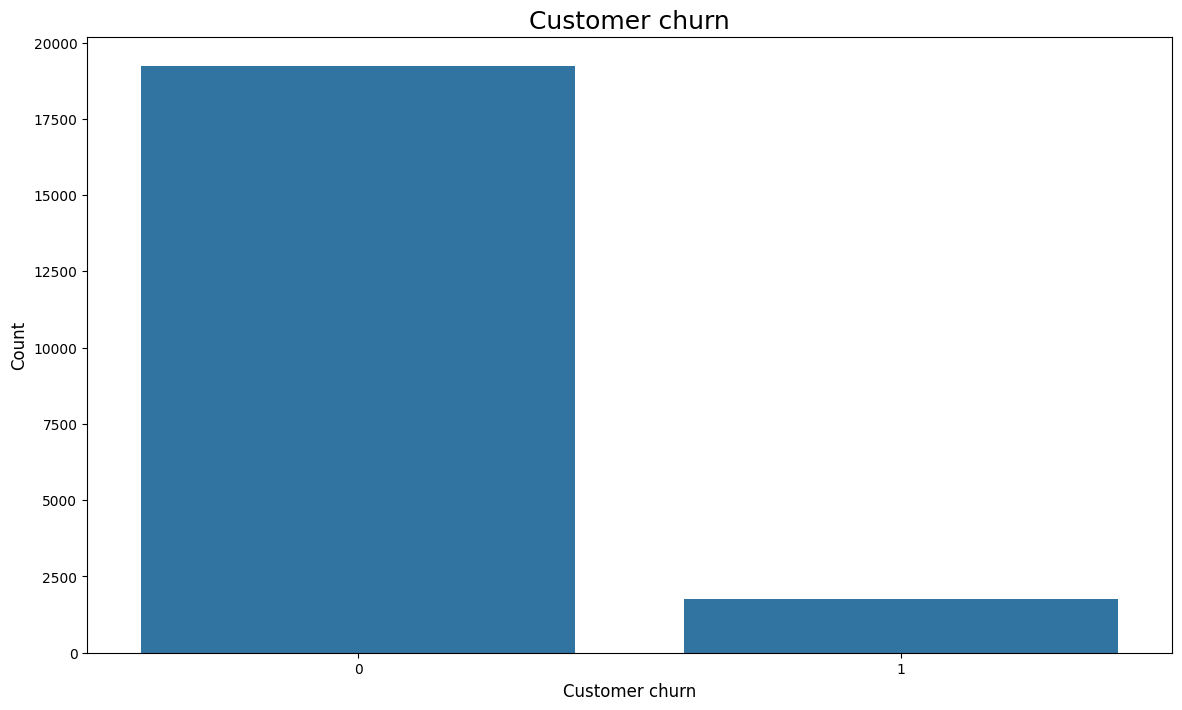

In [435]:
# Visualize churn distribution
plot_countplot(telecom_df_high_val_cust, 'churn_probability', None, 'Customer churn', 'Count', 'Customer churn distribution')

#### Box Plot - total_rech_amt against churn

['arpu_6', 'arpu_7', 'arpu_8']


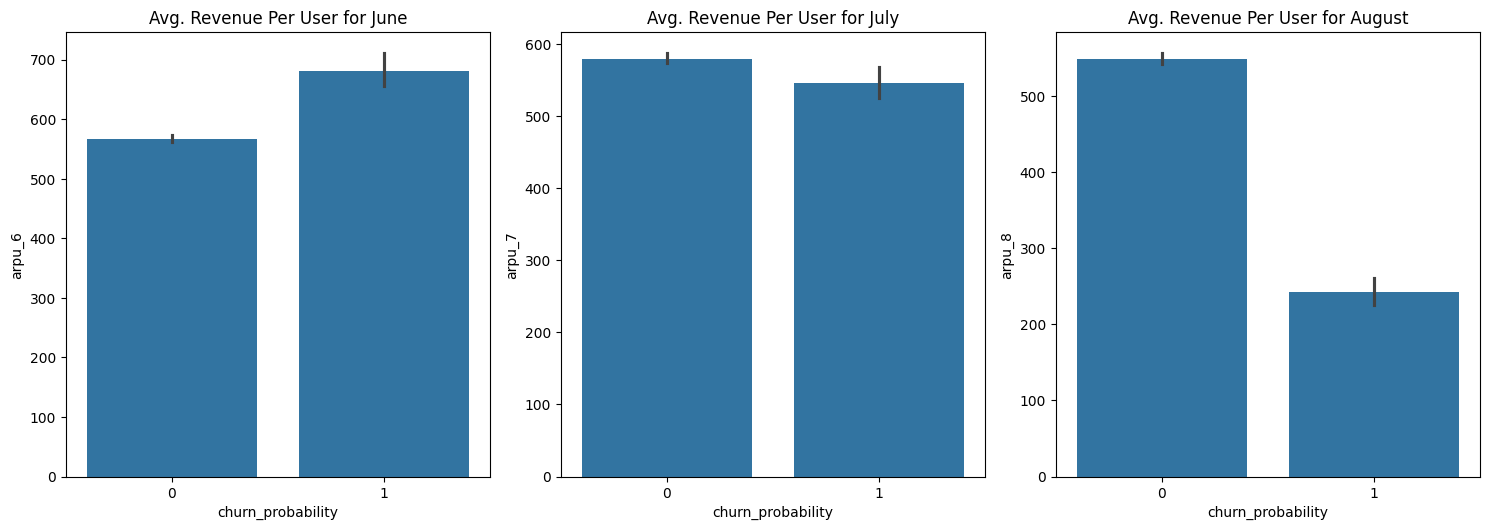

In [436]:
# Visualising Average Revenue per user
arpu_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'arpu_[6-8]')
plot_bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, telecom_df_high_val_cust)

Observation: The decline in the Average Revenue Per User (ARPU) in month of August suggests churn.

['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']


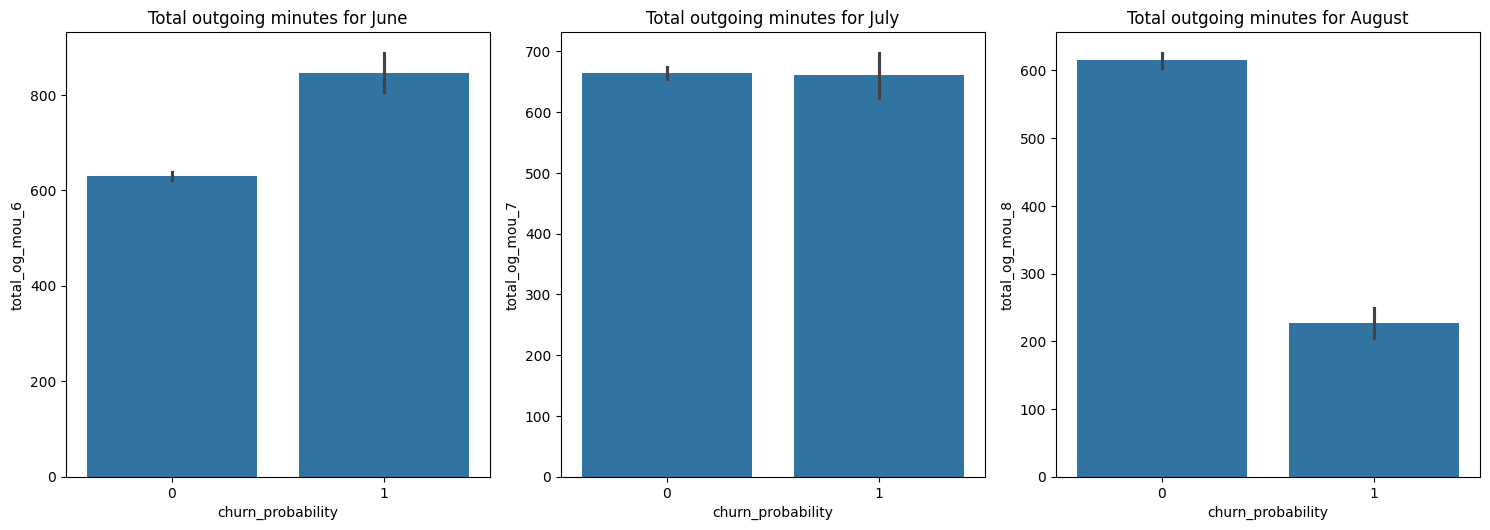

In [437]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'total_og_mou_[6-8]')
plot_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, telecom_df_high_val_cust)

Observation: The decline in the Total outgoing minutes in month of August suggests churn.

['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


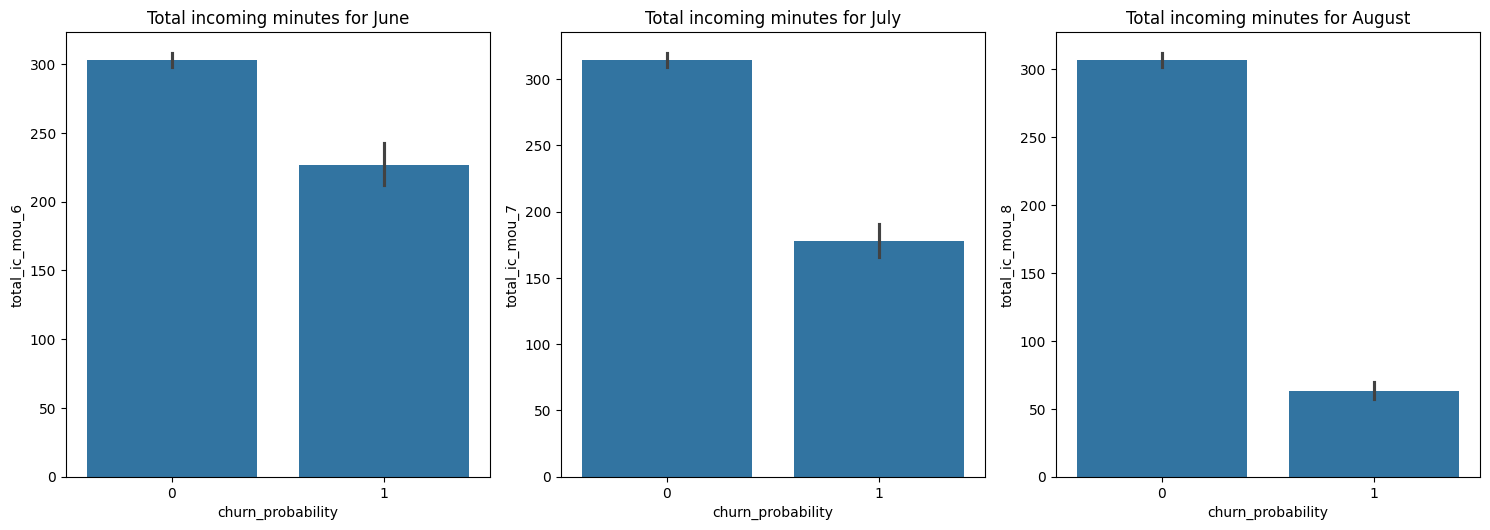

In [438]:
# Visualising incoming minutes of usage
total_ic_mou_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'total_ic_mou_[6-8]')
plot_bar_graph('Total incoming minutes', ['June', 'July', 'August'], total_ic_mou_cols, telecom_df_high_val_cust)

Observation: The decline in the Total incoming minutes in month of August suggests churn.

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']


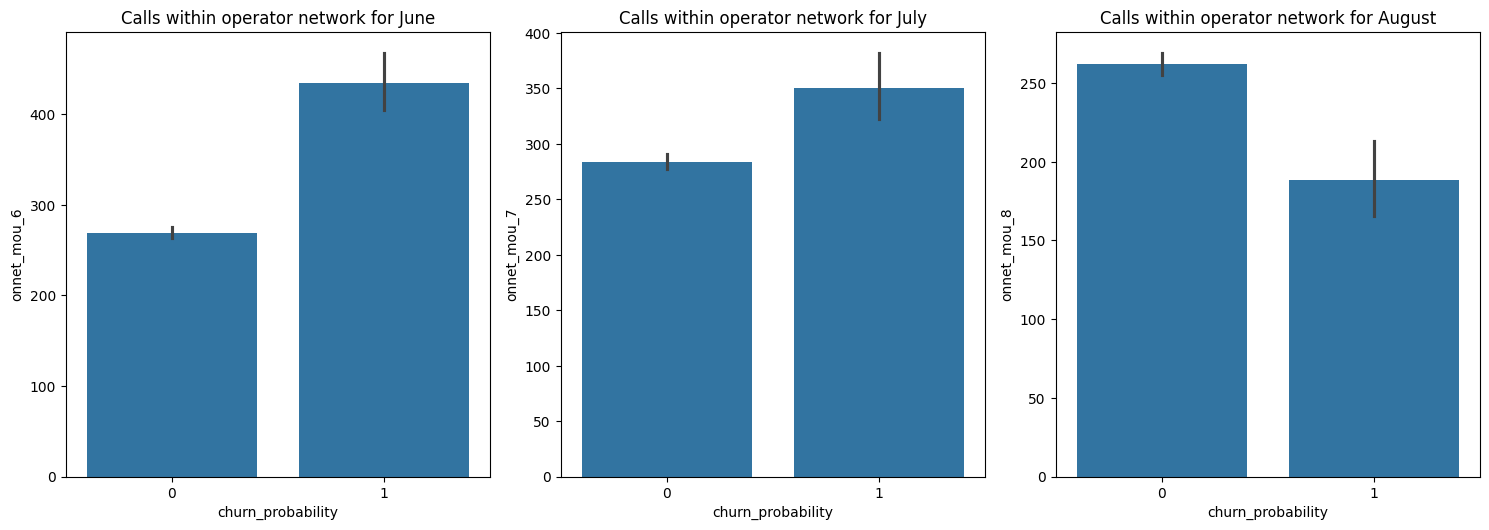

In [439]:
# Visualizing all types of calls within the operator's network.
onnet_mou_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'onnet_mou_[6-8]')
plot_bar_graph('Calls within operator network', ['June', 'July', 'August'], onnet_mou_cols, telecom_df_high_val_cust)

Observation: The decline in the Calls within operator network in month of August suggests churn.

['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']


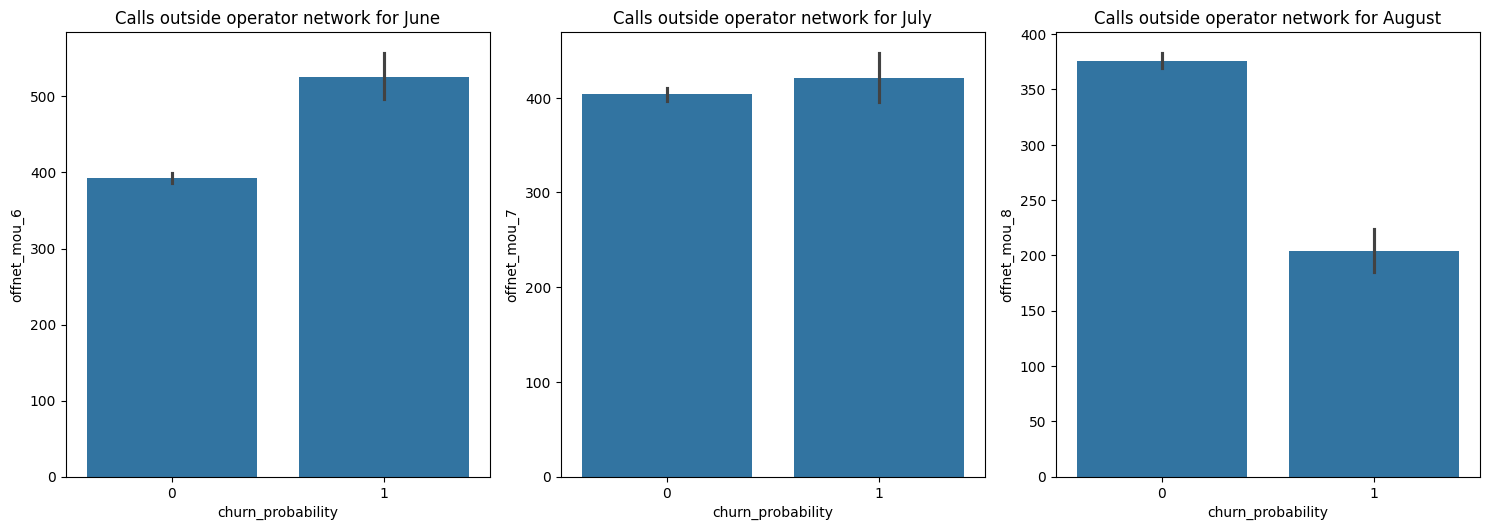

In [440]:
# Visualizing all types of calls made outside the operator network.
offnet_mou_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'offnet_mou_[6-8]')
plot_bar_graph('Calls outside operator network', ['June', 'July', 'August'], offnet_mou_cols, telecom_df_high_val_cust)

Observation: The decline in the Calls outside operator network in month of August suggests churn.

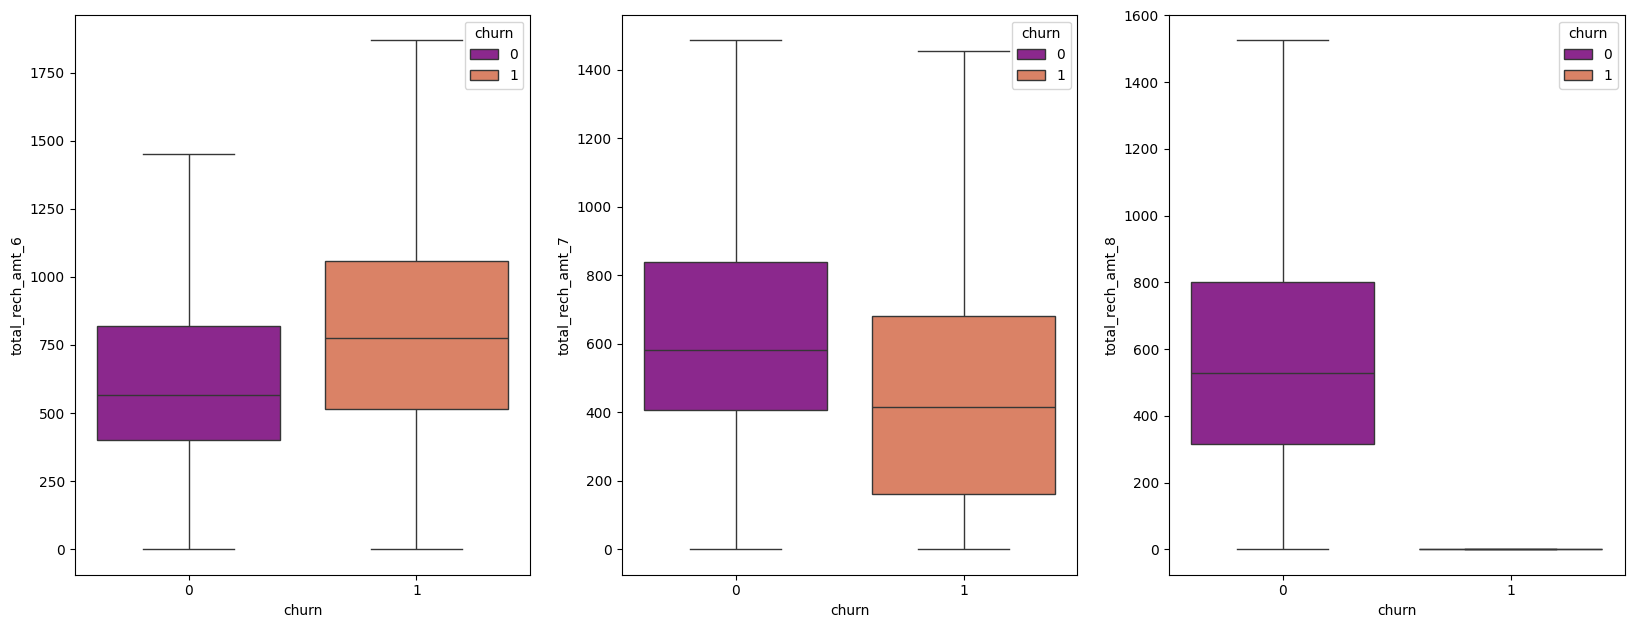

In [441]:
# Ploting for total recharge amount:
plot_box_chart(telecom_df_high_val_cust, 'total_rech_amt', 'churn')

Observations : We can see a drop in the total recharge amount for churned customers in the 8th Month (Action Phase).

#### Box Plot - total_rech_amt_data against churn

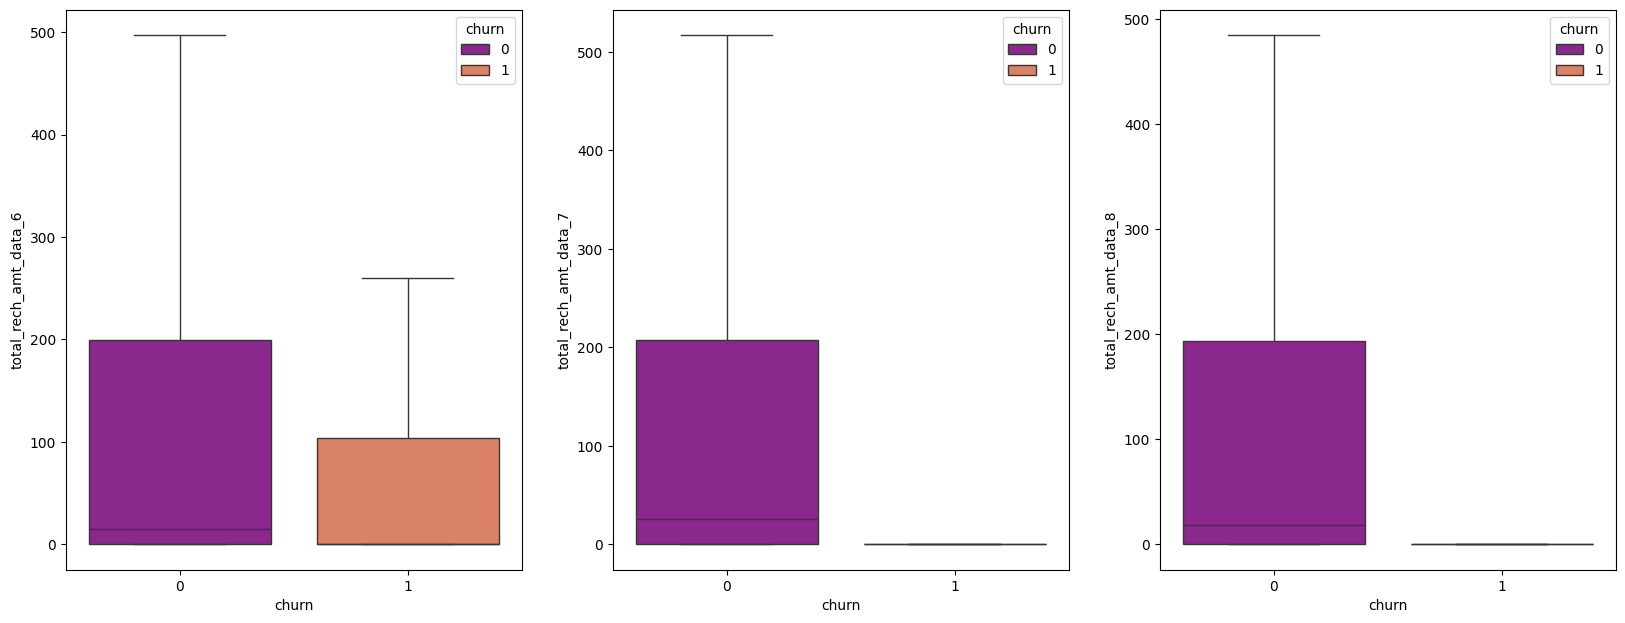

In [442]:
# Ploting for total recharge amount for data:
plot_box_chart(telecom_df_high_val_cust, 'total_rech_amt_data', 'churn')

#### Box Plot - max_rech_amt

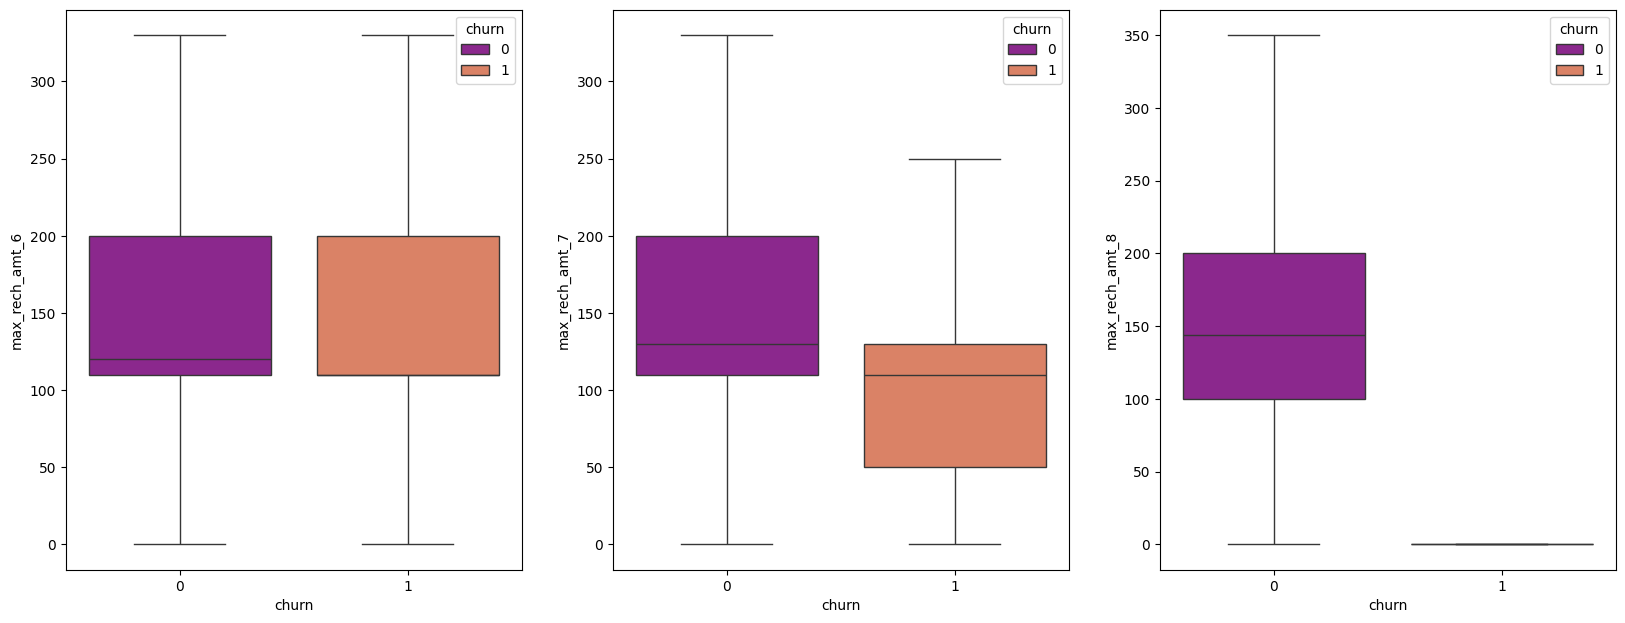

In [443]:
# Ploting for maximum recharge amount for data:
plot_box_chart(telecom_df_high_val_cust, 'max_rech_amt', 'churn')

Observations : We can see that there is a huge drop in maximum recharge amount for data in the 8th month (action phase) for churned customers.

#### Box Plot - total_rech_num

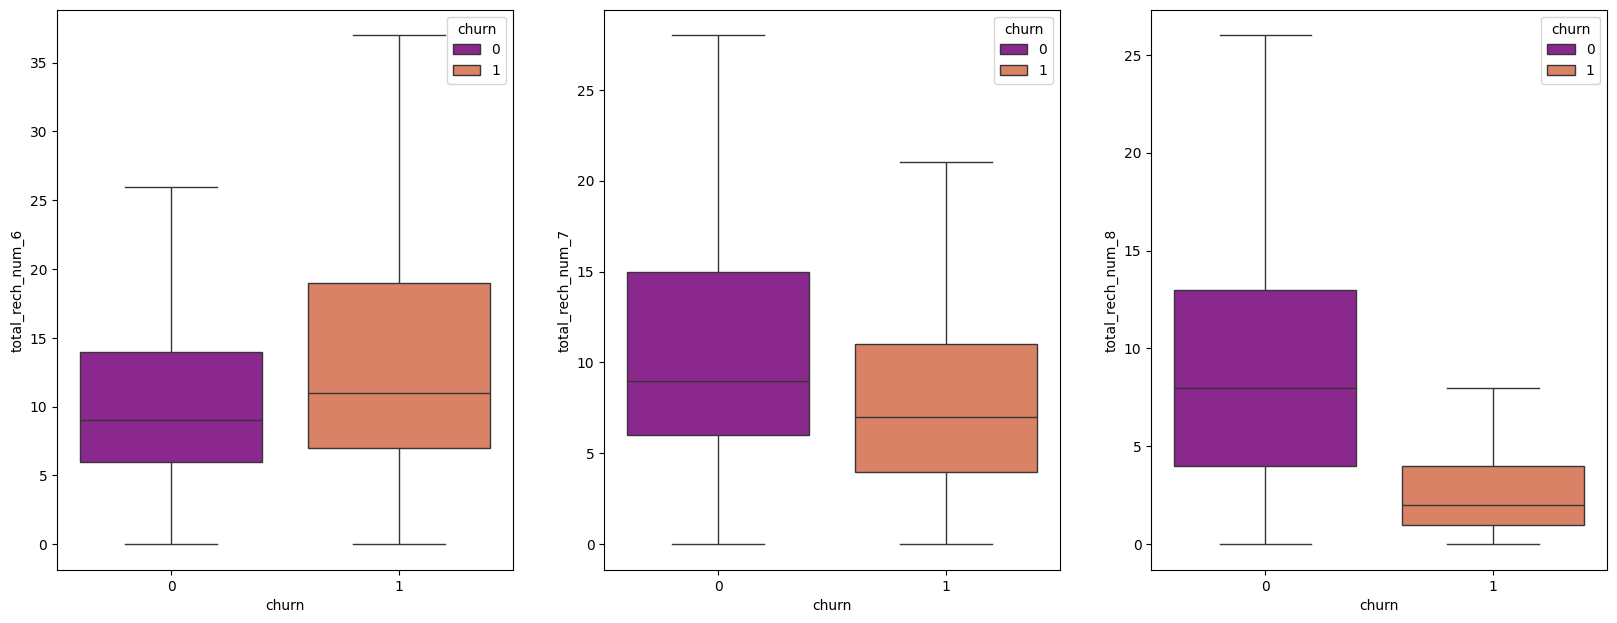

In [444]:
#Ploting for Total recharge for Number:
plot_box_chart(telecom_df_high_val_cust, 'total_rech_num', 'churn')

Observations : We can see that there is a huge drop in total recharge number also in the 8th month (action phase) for churned customers.

In [445]:
# get null counts of maximum recharge data
max_rech_data_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'max_rech_data_[6-8]')
max_rech_data_null_counts = get_null_counts_map(telecom_df_high_val_cust, max_rech_data_cols)
max_rech_data_null_counts

['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']


{'max_rech_data_6': 10585, 'max_rech_data_7': 10372, 'max_rech_data_8': 10854}

In [446]:
telecom_df_high_val_cust = impute_null_columns(telecom_df_high_val_cust, max_rech_data_cols)

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/3652335906.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(np.NaN,0.0)


### Box Plot - max_rech_data

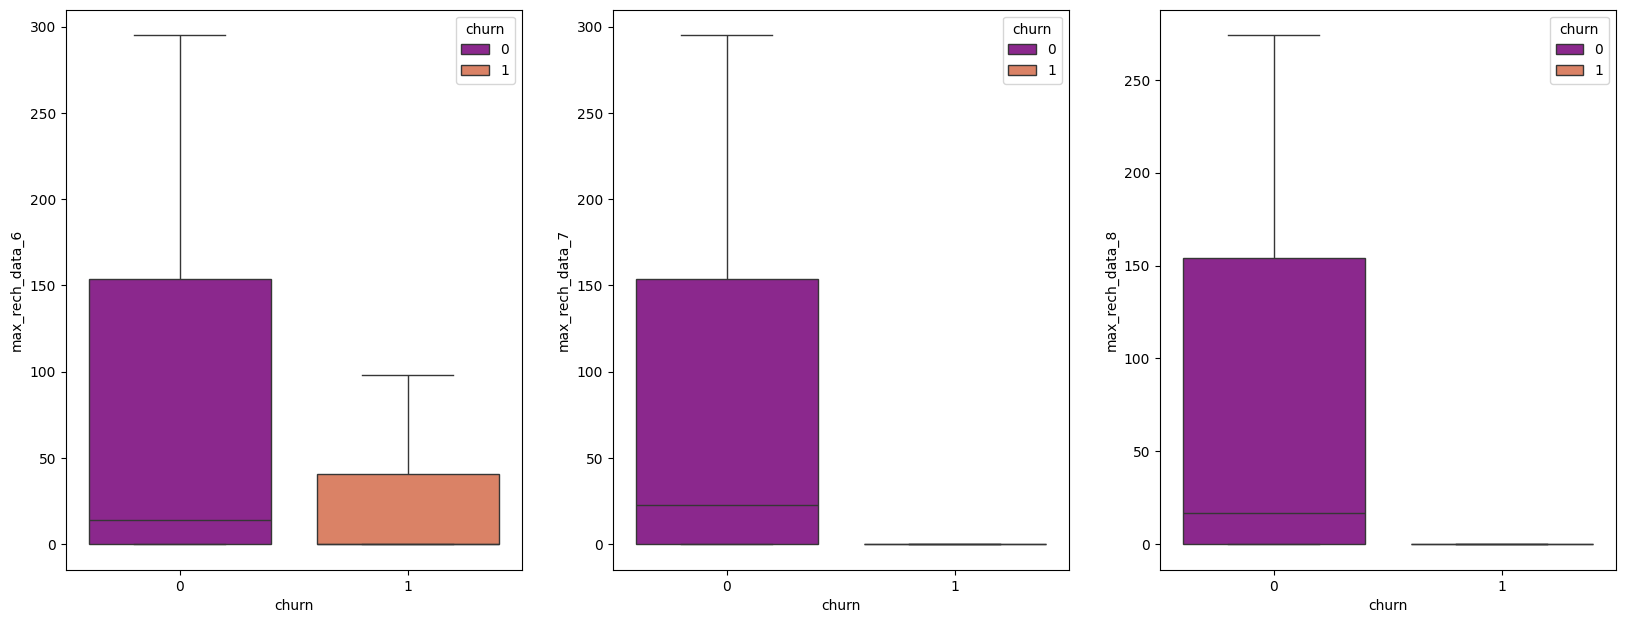

In [447]:
# Ploting for maximum recharge for data:
plot_box_chart(telecom_df_high_val_cust, 'max_rech_data','churn')

Observations : We can see that there is a huge drop in maximum recharge for data also in the 8th month (action phase) for churned customers.

In [448]:
#Extracting the last day recharge amount columns
last_day_rech_amt = filter_columns_by_regex(telecom_df_high_val_cust, 'day')

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']


### Box Plot - last_day_rch_amt

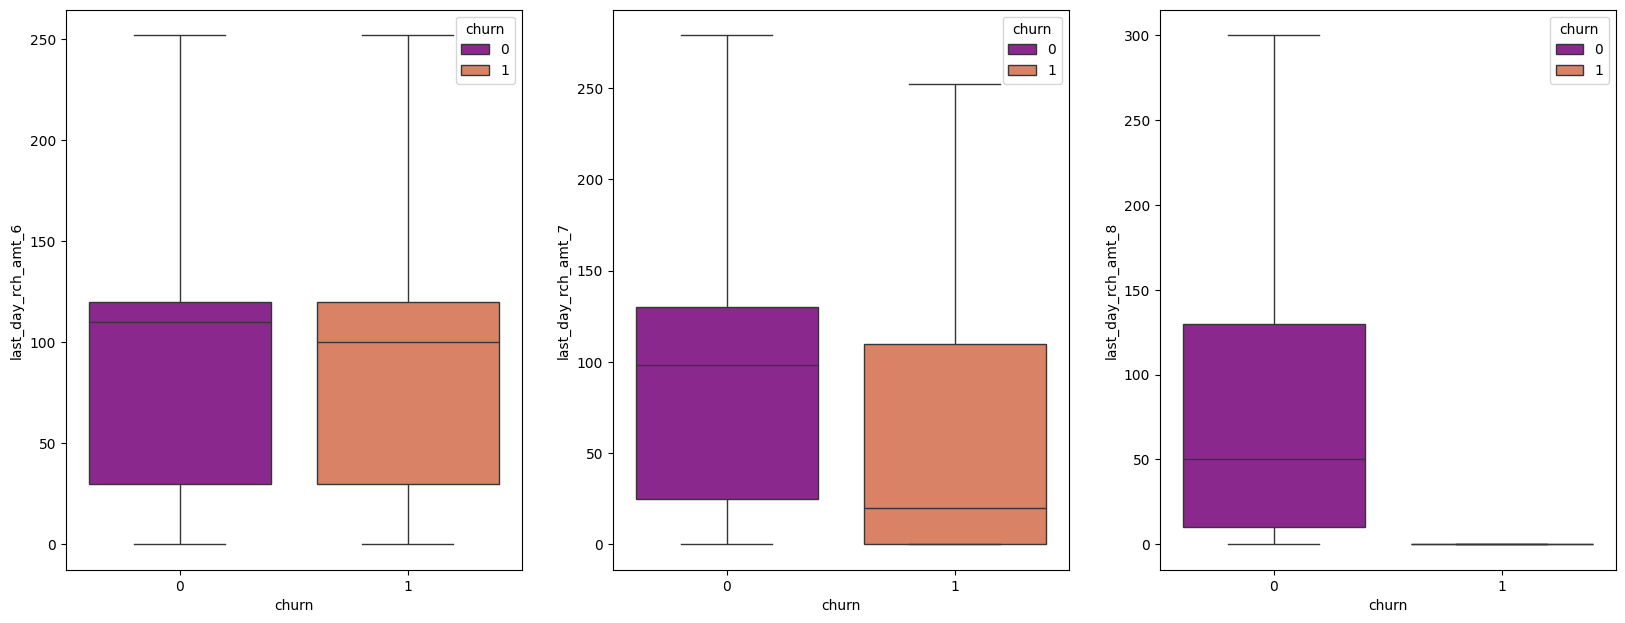

In [449]:
# Ploting for last day recharge amount:
plot_box_chart(telecom_df_high_val_cust,'last_day_rch_amt','churn')

Observations : We are getting a huge drop in 8th month recharge amount for churned customers.

### 2G and 3G usage related Features

In [450]:
usage_2g_and_3g = filter_columns_by_regex(telecom_df_high_val_cust, '2g|3g')

['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']


In [451]:
# Calculate the percentage of null values for 2g and 3g columns
usage_2g_and_3g_null_counts_map = get_null_counts_map(telecom_df_high_val_cust, usage_2g_and_3g.to_list())
usage_2g_and_3g_null_counts_map

{'count_rech_2g_6': 10585,
 'count_rech_2g_7': 10372,
 'count_rech_2g_8': 10854,
 'count_rech_3g_6': 10585,
 'count_rech_3g_7': 10372,
 'count_rech_3g_8': 10854,
 'vol_2g_mb_6': 0,
 'vol_2g_mb_7': 0,
 'vol_2g_mb_8': 0,
 'vol_3g_mb_6': 0,
 'vol_3g_mb_7': 0,
 'vol_3g_mb_8': 0,
 'arpu_3g_6': 10585,
 'arpu_3g_7': 10372,
 'arpu_3g_8': 10854,
 'arpu_2g_6': 10585,
 'arpu_2g_7': 10372,
 'arpu_2g_8': 10854,
 'monthly_2g_6': 0,
 'monthly_2g_7': 0,
 'monthly_2g_8': 0,
 'sachet_2g_6': 0,
 'sachet_2g_7': 0,
 'sachet_2g_8': 0,
 'monthly_3g_6': 0,
 'monthly_3g_7': 0,
 'monthly_3g_8': 0,
 'sachet_3g_6': 0,
 'sachet_3g_7': 0,
 'sachet_3g_8': 0,
 'aug_vbc_3g': 0,
 'jul_vbc_3g': 0,
 'jun_vbc_3g': 0}

In [452]:
usage_2g_and_3g_null_counts = []
for key, value in usage_2g_and_3g_null_counts_map.items():
    if value > 1:
        usage_2g_and_3g_null_counts.append(key)
usage_2g_and_3g_null_counts

['count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8']

In [453]:
# drop null values columns
drop_cols(telecom_df_high_val_cust, usage_2g_and_3g_null_counts)

Dropped columns:  ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/894478368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


In [454]:
telecom_df_high_val_cust.shape

(20984, 152)

### Box Plot - vol_2g_mb

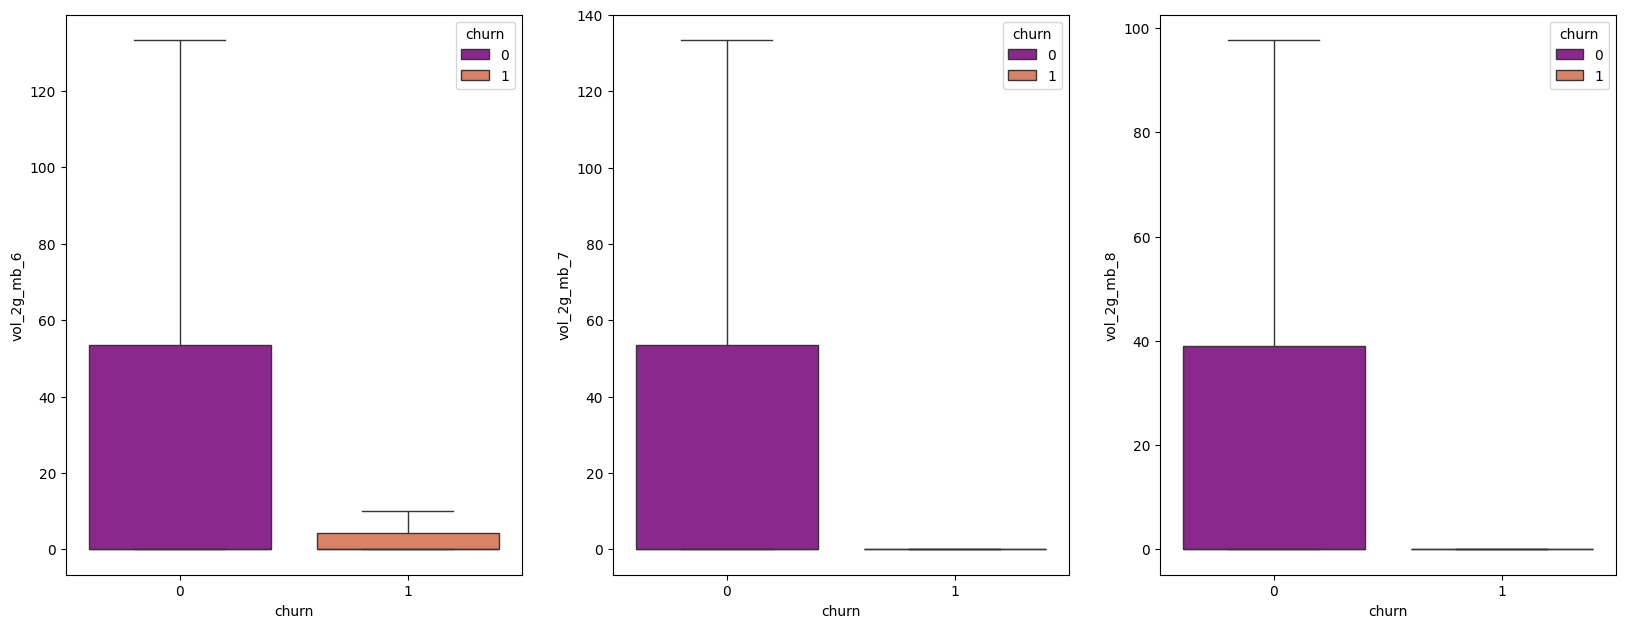

In [455]:
# Ploting for volume of 2G and 3G usage columns:
plot_box_chart(telecom_df_high_val_cust, 'vol_2g_mb', 'churn')

### Box Plot - vol_3g_mb

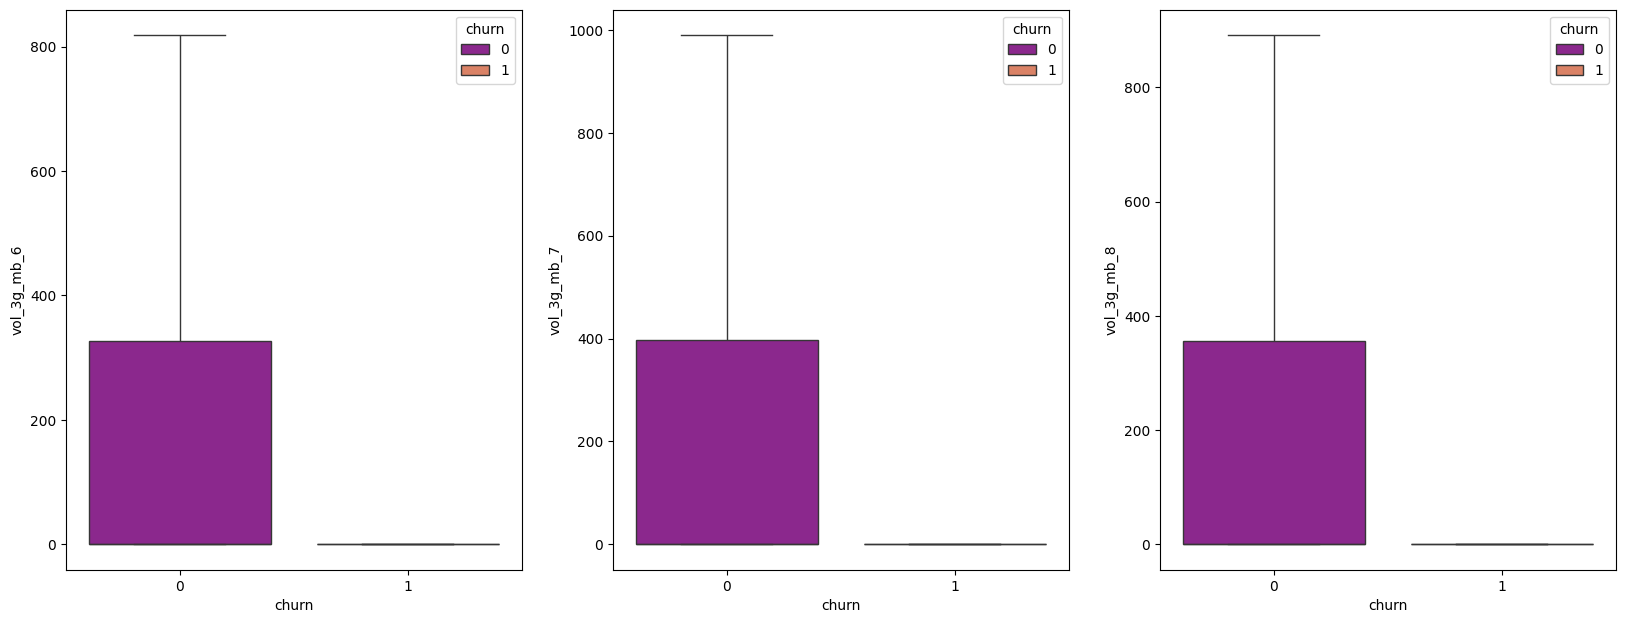

In [456]:
plot_box_chart(telecom_df_high_val_cust, 'vol_3g_mb', 'churn')

Observations : We have two observations from above:
<ol>
<li> 2G and 3G usage for churned customers drops in 8th month
<li> We also see that 2G/3G usage is higher for non-churned customers indicating that churned customers might be from areas where 2G/3G service is not properly available.
</ol>

### Box Plot - monthly_2g

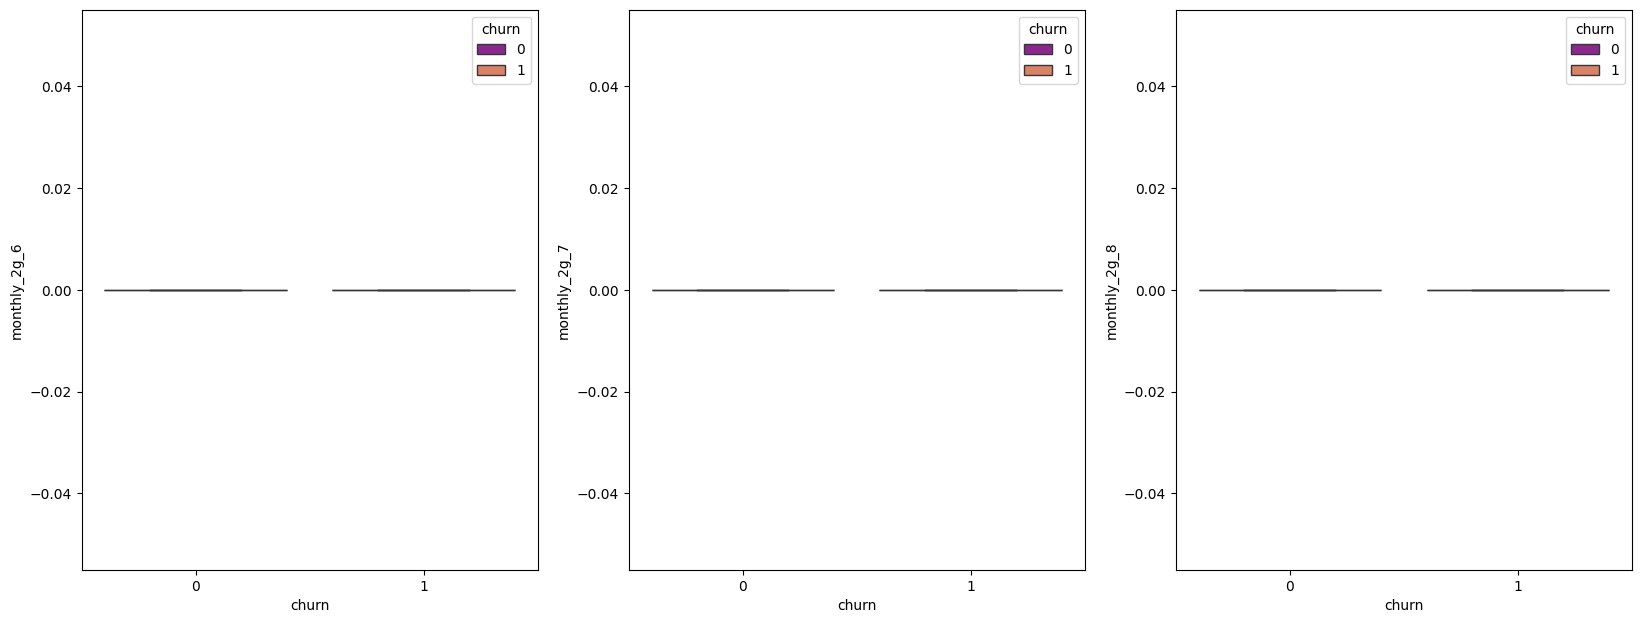

In [457]:
# Ploting for monthly subscription :
plot_box_chart(telecom_df_high_val_cust, 'monthly_2g', 'churn')

Observations : Value range is very low, hence graph is not giving us proper justification result .Hence doing analysis by checking mean value.


In [458]:
# let's check monthly 2G/3G service schemes
monthly_subcription_2g_3g = filter_columns_by_regex(telecom_df_high_val_cust, 'monthly_2g|monthly_3g')

['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8']


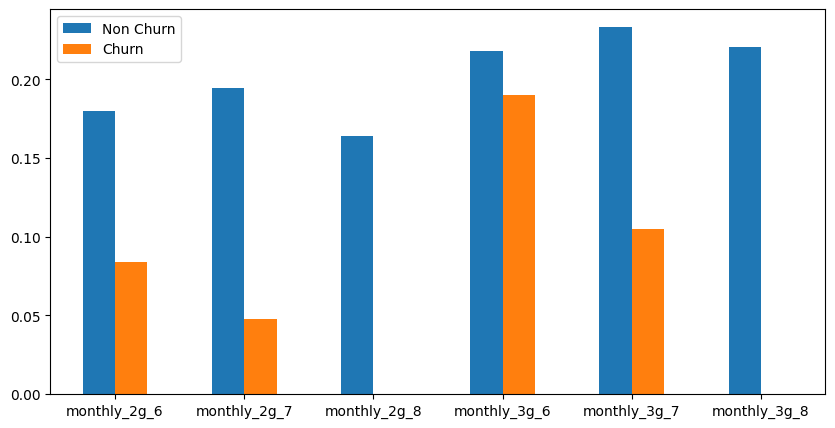

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.179916,0.194334,0.164087,0.218077,0.232898,0.220699
Churn,0.083697,0.047951,0.000000,0.190061,0.104621,0.000000


In [459]:
#Plotting monthly 2g and 3g
plot_mean_bar_chart(telecom_df_high_val_cust, monthly_subcription_2g_3g)

Observations : Again we can see a drop in monthly subscription for churned customers in 8th Month.


### Volume based cost usage related Features

In [460]:
vbc_column = filter_columns_by_regex(telecom_df_high_val_cust, 'vbc_')

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']


In [461]:
# Renaming month named vbc columns to 6,7,8 format
telecom_df_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'}, inplace=True)

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/3052465245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_df_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'}, inplace=True)


In [462]:
vbc_column = filter_columns_by_regex(telecom_df_high_val_cust, 'vbc_3g')

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']


### Box Plot - vbc_3g

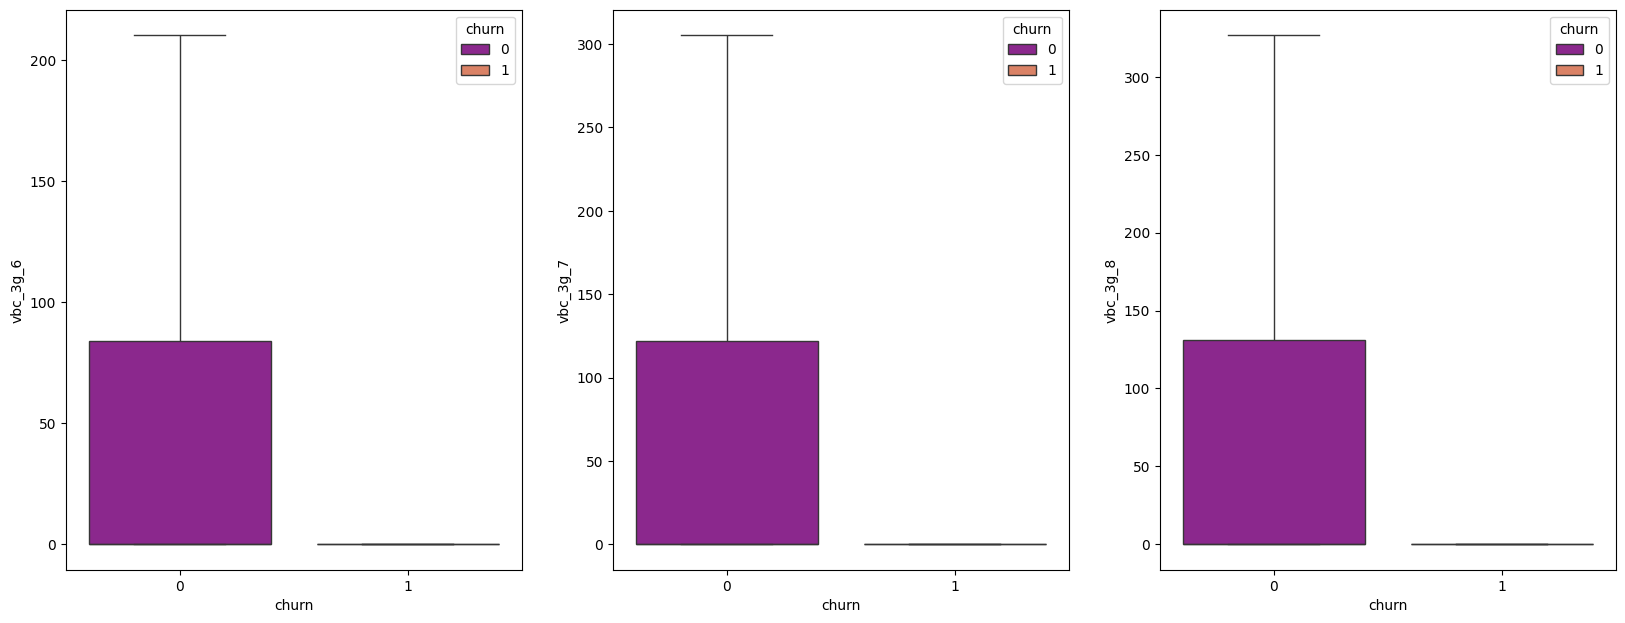

In [463]:
# Ploting for volume based cost :
plot_box_chart(telecom_df_high_val_cust, 'vbc_3g', 'churn')

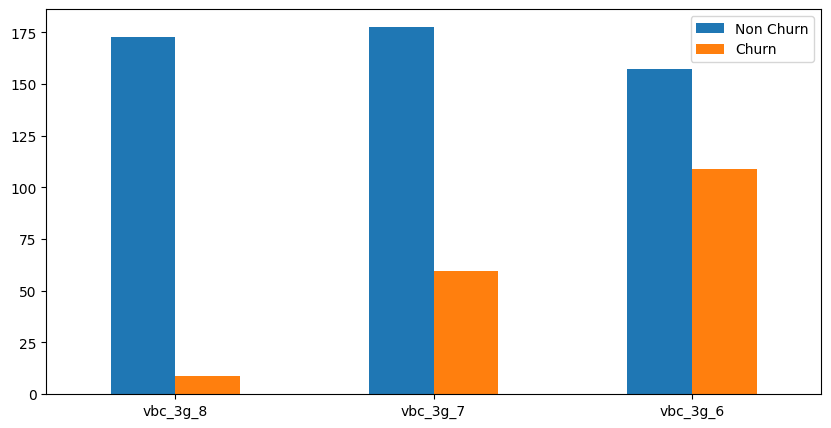

,vbc_3g_8,vbc_3g_7,vbc_3g_6
Non Churn,172.612398,177.300444,157.238009
Churn,8.649189,59.741421,108.796513


In [464]:
plot_mean_bar_chart(telecom_df_high_val_cust, vbc_column)

Observations : Significantly it showing that volume based cost for 3G is much lower for Churned customers as compared to Non-Churned Customers and also there is a drop in vbc in 8th month

In [465]:
# Checking Service schemes with validity smaller than a month for 2G/3G
SC_2g_or_3g_col = filter_columns_by_regex(telecom_df_high_val_cust, 'sachet_2g|sachet_3g')

['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


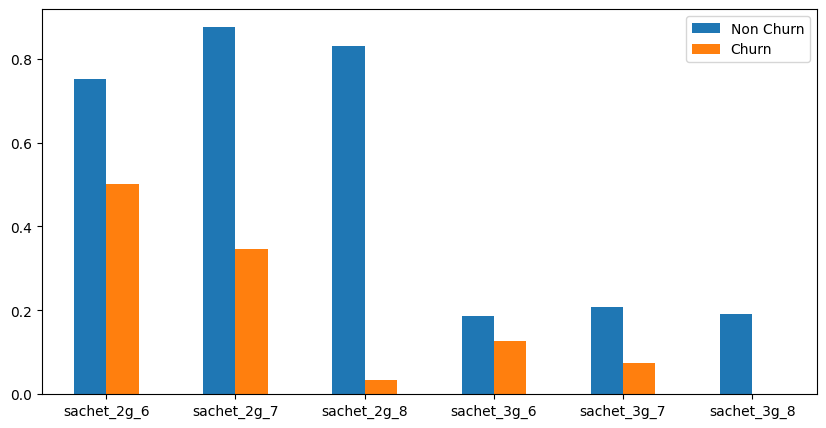

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churn,0.75087,0.874326,0.829611,0.187075,0.207693,0.191511
Churn,0.50218,0.345248,0.034002,0.126417,0.074978,0.000000


In [466]:
plot_mean_bar_chart(telecom_df_high_val_cust, SC_2g_or_3g_col)

Observations : We can see the drop in sachet services in 8th month for churned cutsomers

### Box Plot - vbc_3g

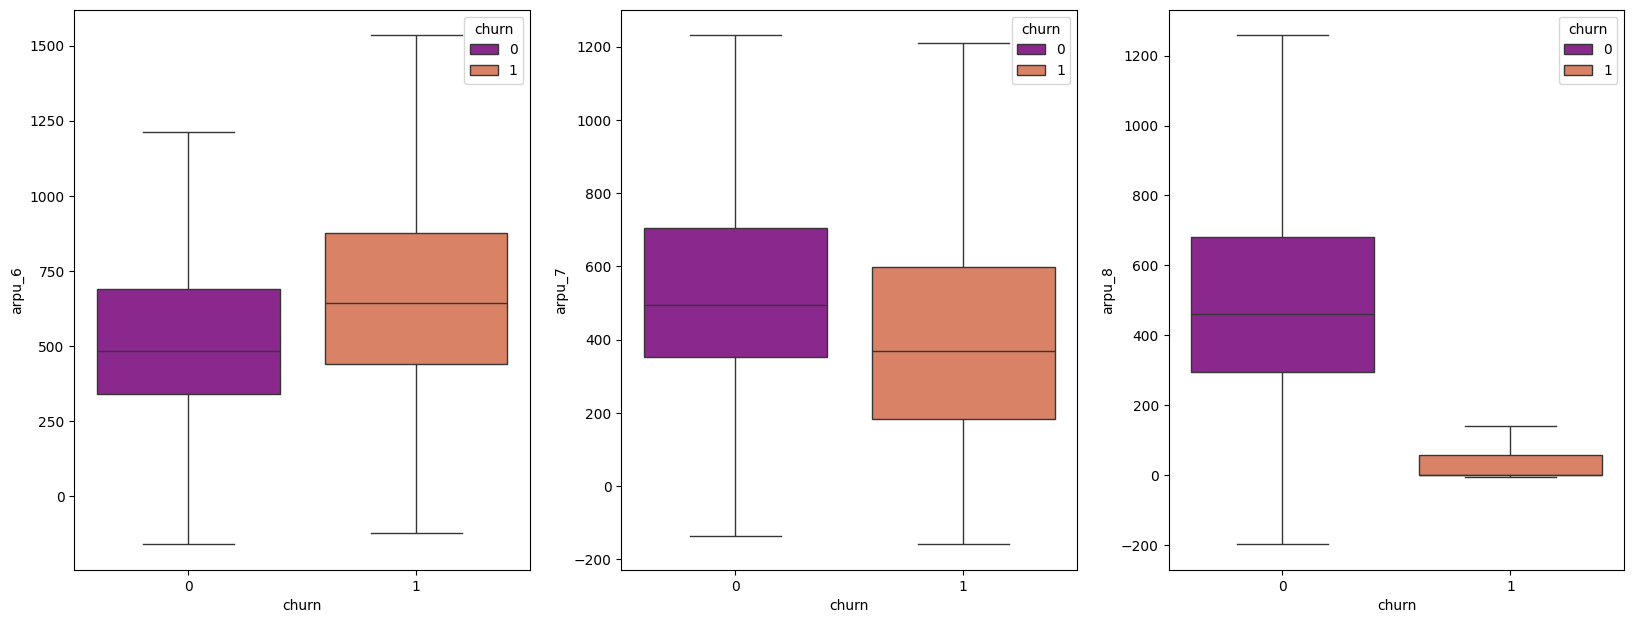

In [467]:
# Plotting arpu
plot_box_chart(telecom_df_high_val_cust, 'arpu', 'churn')

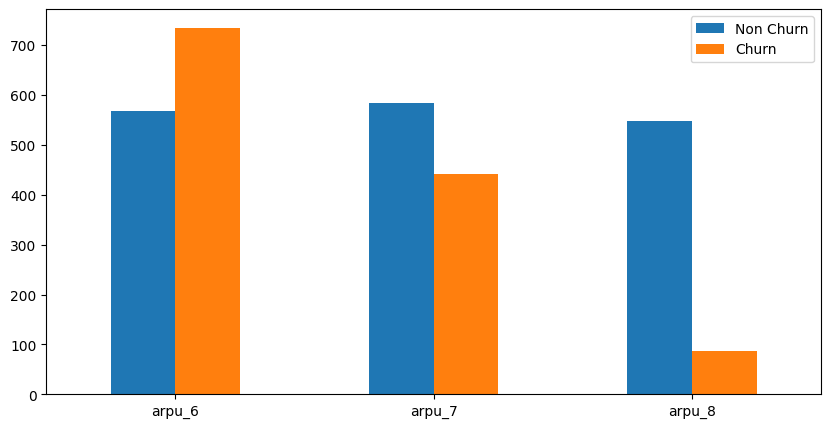

,arpu_6,arpu_7,arpu_8
Non Churn,567.250089,584.317433,548.193665
Churn,735.166869,441.618135,86.896745


In [468]:
plot_mean_bar_chart(telecom_df_high_val_cust, arpu_cols)

Observations : We can see that huge drops for Arpu in 8th month for churned customers

###  Minutes of usage - voice calls related Features

In [469]:
mou_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'mou')

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6'

Observations : So for all minutes of usage columns the maximum missing % is 3.91 , means in these case the customer has not been used at all for that particular call type, thus we can fill the missing values with zero


In [470]:
telecom_df_high_val_cust = impute_null_columns(telecom_df_high_val_cust, mou_cols.to_list())

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/3652335906.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(np.NaN,0.0)


In [471]:
mou_og_cols6 = filter_columns_by_regex(telecom_df_high_val_cust, '.*_og_.*mou_6')

['roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'total_og_mou_6']


In [472]:
telecom_df_high_val_cust.loc[:,mou_og_cols6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000
mean,28.558768,88.412276,170.866712,6.647443,1.549121,265.934996,177.757522,192.617813,1.894971,372.274326,2.383451,5.842503,647.098117
std,121.136006,233.410894,249.214341,20.571314,6.563695,380.845586,411.211260,412.078561,12.622126,612.028902,53.090602,19.016429,682.983177
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.137500,24.380000,0.000000,0.000000,41.290000,0.000000,0.000000,0.000000,1.750000,0.000000,0.000000,176.330000
50%,0.000000,28.040000,86.960000,0.260000,0.000000,140.875000,6.020000,24.200000,0.000000,73.010000,0.000000,0.160000,464.255000
75%,0.000000,83.132500,221.032500,4.765000,0.000000,350.777500,140.250000,182.682500,0.000000,535.937500,0.000000,5.015000,885.795000
max,3775.110000,6431.330000,4696.830000,617.580000,271.440000,10643.380000,7366.580000,8314.760000,628.560000,8432.990000,5900.660000,1023.210000,10674.030000


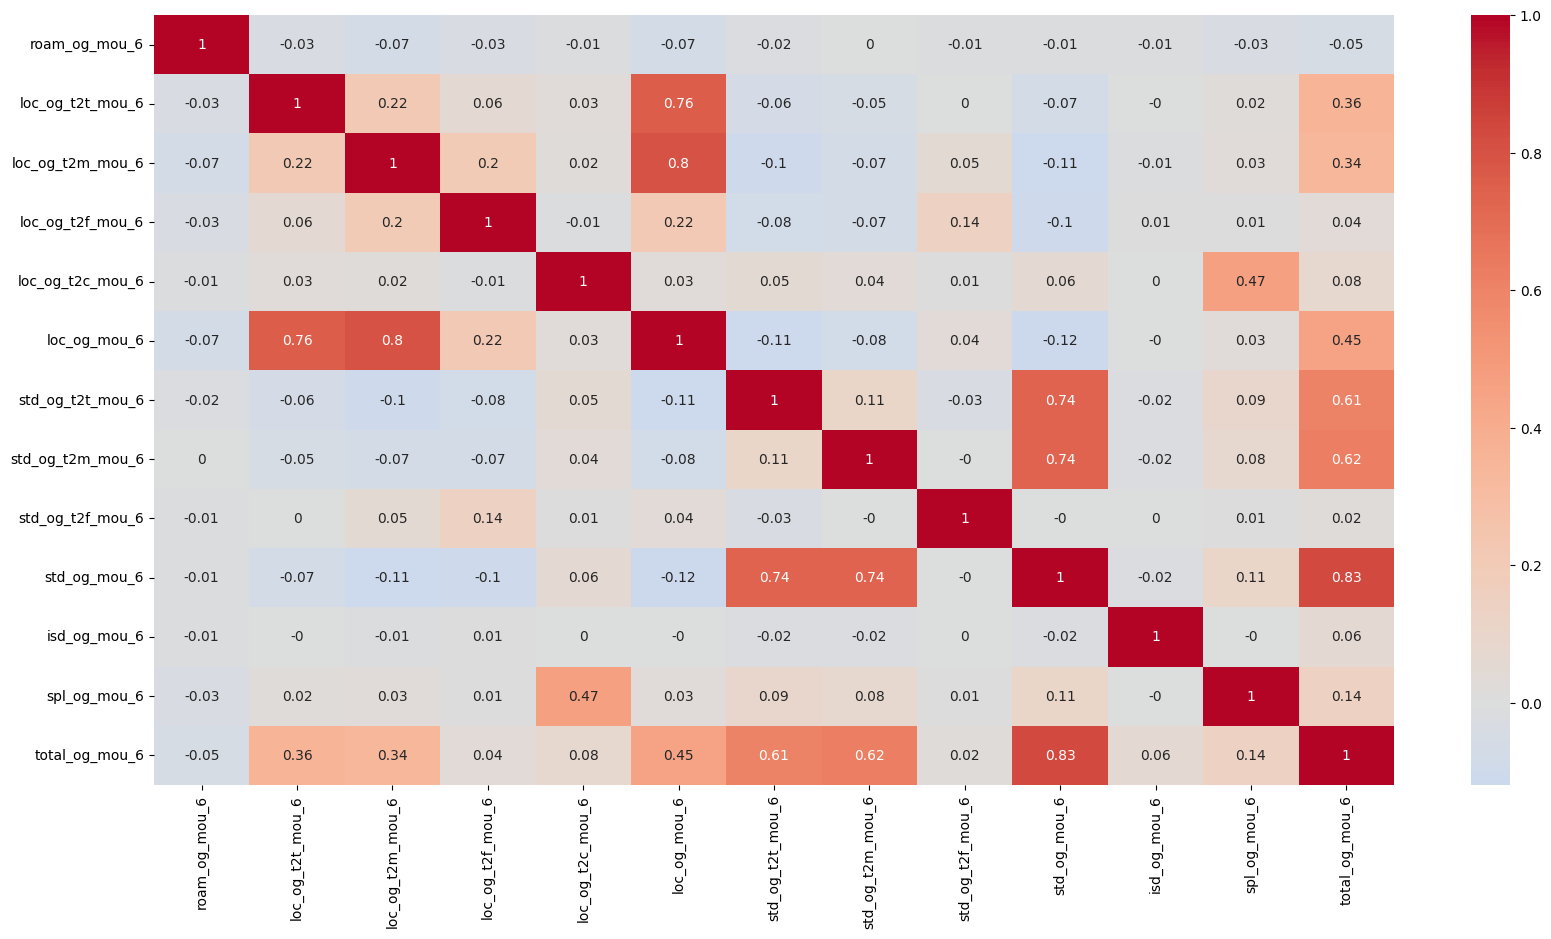

In [473]:
plot_heatmap(telecom_df_high_val_cust, mou_og_cols6)

In [474]:
#drop columns with total_og_mou|std_og_mou|loc_og_mou
list_total_og_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'total_og_mou|std_og_mou|loc_og_mou')

drop_cols(telecom_df_high_val_cust, list_total_og_cols)

['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
Dropped columns:  ['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/894478368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


In [475]:
telecom_df_high_val_cust.shape

(20984, 143)

In [476]:
#Checking for incoming mou variables
mou_ic_cols6 = filter_columns_by_regex(telecom_df_high_val_cust, '.*_ic_.*mou_6')

['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6']


In [477]:
telecom_df_high_val_cust.loc[:,mou_ic_cols6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.00000,20984.000000,20984.000000,20984.000000,20984.000000
mean,16.611307,66.864156,153.497267,15.755854,236.127060,15.217241,30.273796,2.91167,48.406447,296.683751,0.063772,10.848323
std,77.514092,158.017983,215.644988,45.059876,309.688761,70.835910,95.300274,21.05211,131.480014,357.918139,0.200656,76.904438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.090000,30.660000,0.000000,51.960000,0.000000,0.030000,0.00000,1.600000,80.690000,0.000000,0.000000
50%,0.000000,26.560000,88.225000,2.030000,142.190000,0.630000,5.830000,0.00000,12.885000,194.100000,0.000000,0.000000
75%,0.000000,70.040000,194.345000,12.710000,305.220000,9.195000,25.390000,0.20000,43.980000,381.832500,0.000000,0.000000
max,2613.310000,4363.960000,4450.740000,1373.090000,7454.630000,3038.340000,3613.980000,1351.11000,3929.240000,7716.140000,19.760000,6789.410000


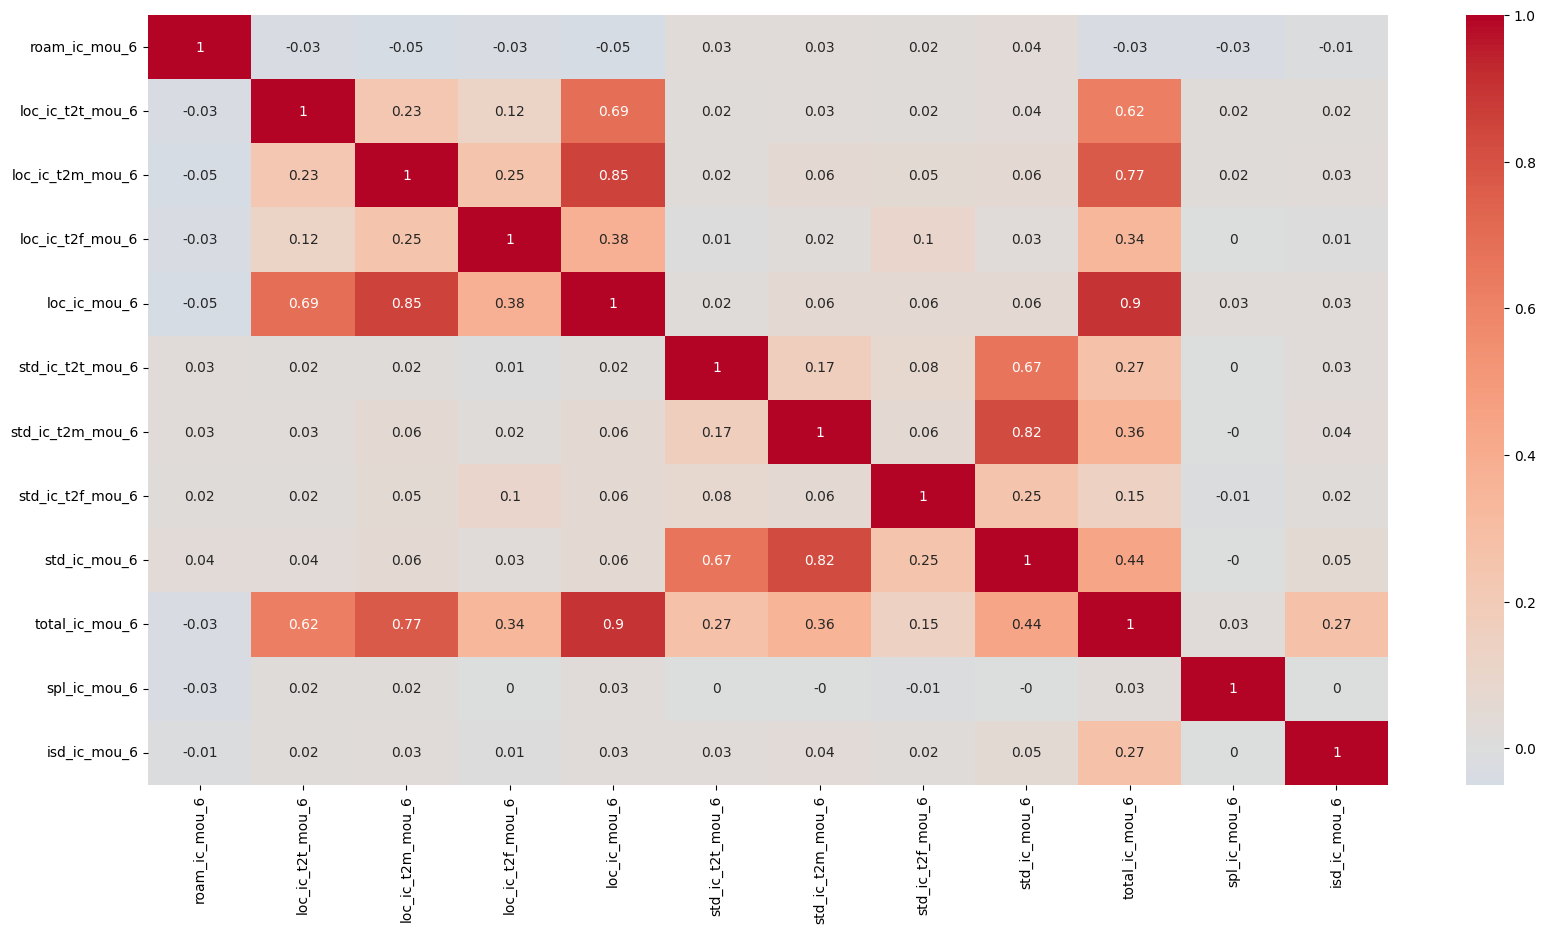

In [478]:
plot_heatmap(telecom_df_high_val_cust, mou_ic_cols6)

Observations : We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.


In [479]:
# drop columns with total_ic_mou|std_ic_mou|loc_ic_mou
list_total_ic_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'total_ic_mou|std_ic_mou|loc_ic_mou')

drop_cols(telecom_df_high_val_cust, list_total_ic_cols)

['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
Dropped columns:  ['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/894478368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


In [480]:
telecom_df_high_val_cust.shape

(20984, 134)

### Offnet Usage related Features

In [481]:
offnet_usage_service_col = filter_columns_by_regex(telecom_df_high_val_cust, 'offnet.*mou')

['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']


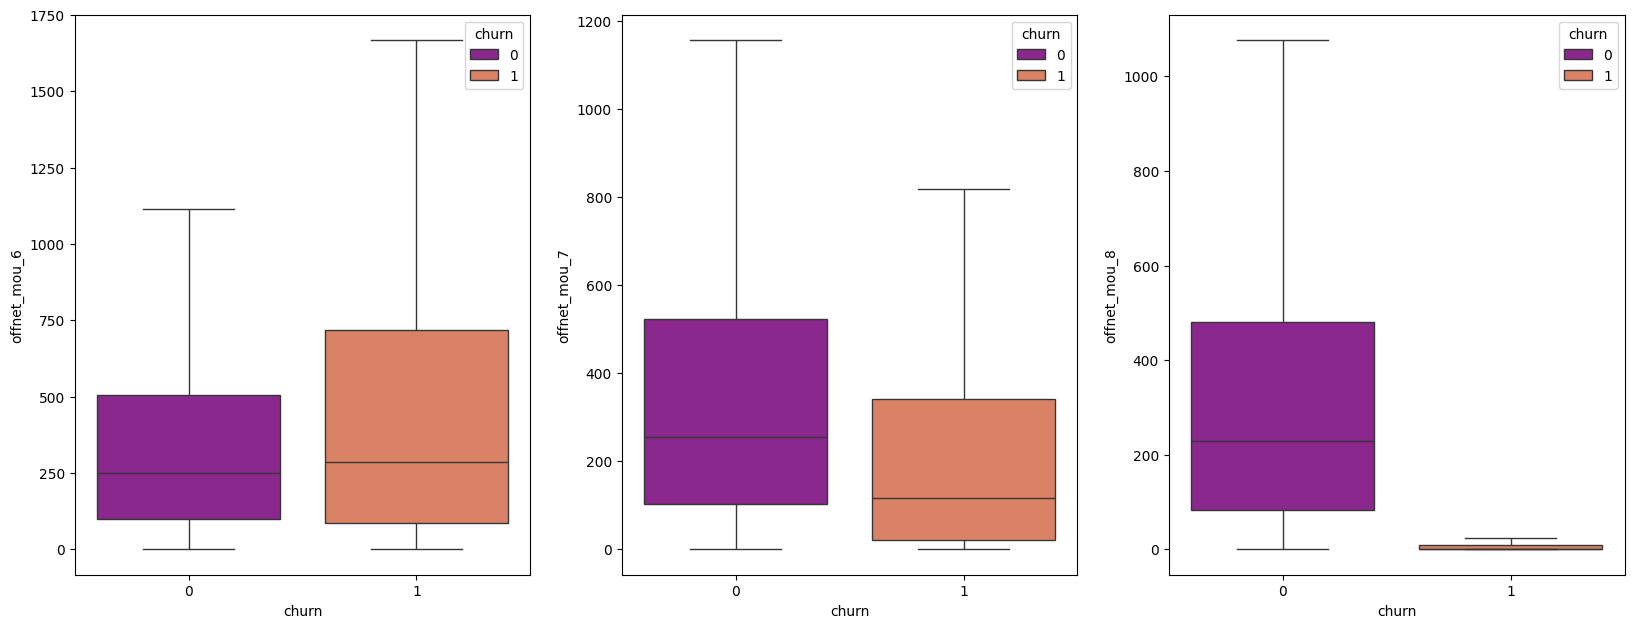

In [482]:
# Offnet mou values for churned and non churned customers
plot_box_chart(telecom_df_high_val_cust, 'offnet_mou', 'churn')

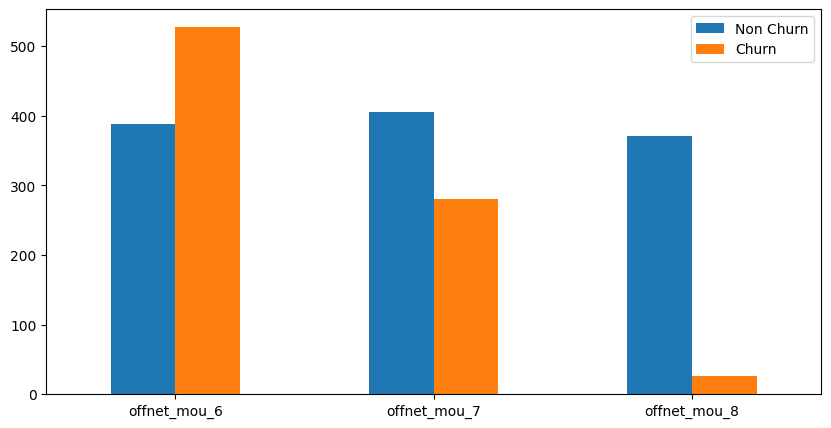

,offnet_mou_6,offnet_mou_7,offnet_mou_8
Non Churn,388.609858,404.815650,371.048317
Churn,526.734603,279.916975,25.760453


In [483]:
plot_mean_bar_chart(telecom_df_high_val_cust, offnet_usage_service_col)

Observations : We can see the drop for offnet mou services in the 8th month


### ONNET : All kind of calls within the same operator network

In [484]:
#minutes of usage related columns
onnet_usage_service = filter_columns_by_regex(telecom_df_high_val_cust, '^onnet.*mou')

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']


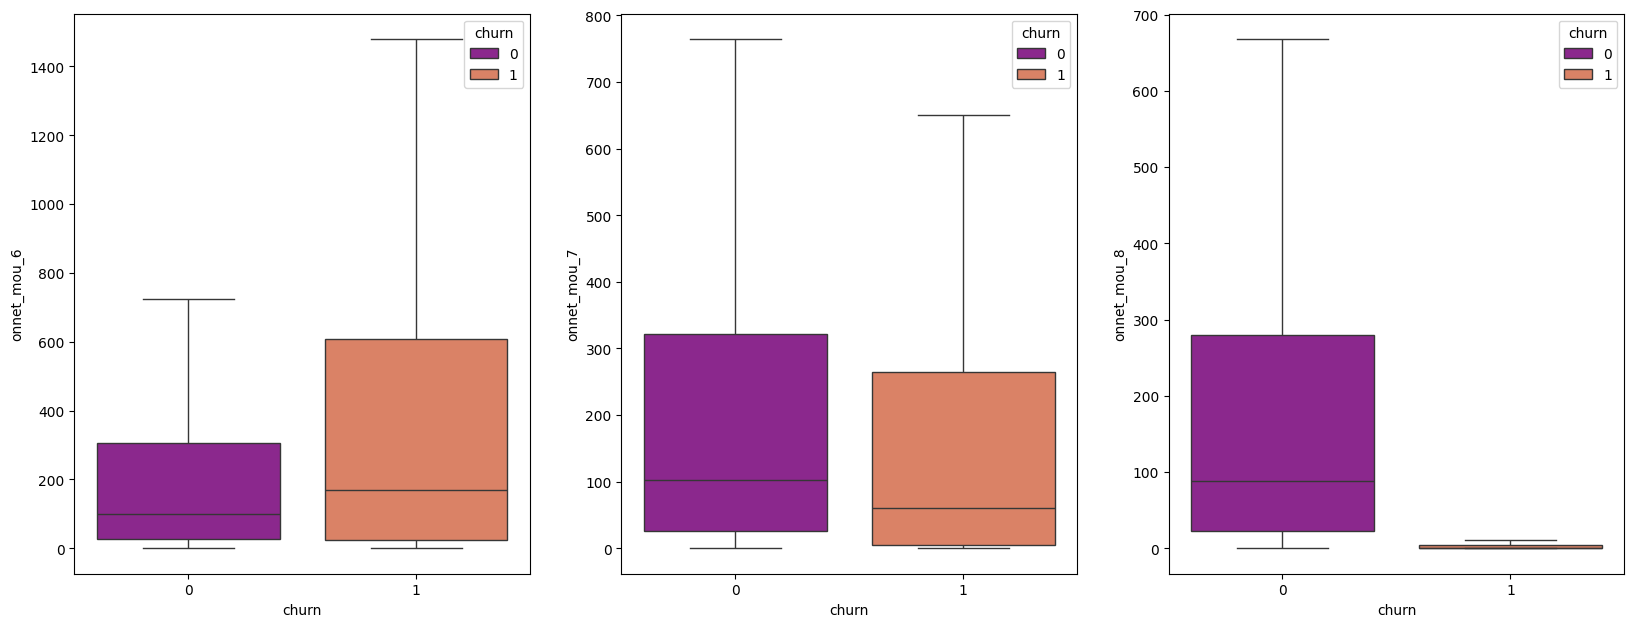

In [485]:
# Plotting offnet
plot_box_chart(telecom_df_high_val_cust, 'onnet_mou', 'churn')

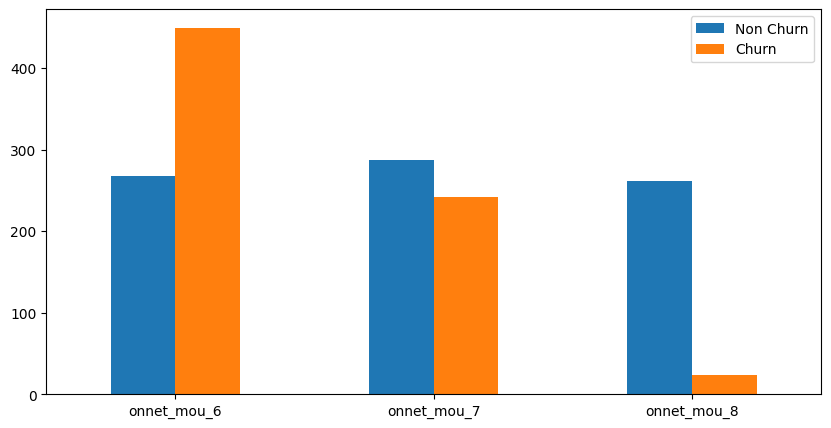

,onnet_mou_6,onnet_mou_7,onnet_mou_8
Non Churn,267.620306,286.692580,261.348319
Churn,449.545283,242.203644,23.864699


In [486]:
plot_mean_bar_chart(telecom_df_high_val_cust, onnet_usage_service)

Observations : We also see that there is a drop in Onnet usage in the 8th month for churned customers


### Tenure Analysis for Customers

In [487]:
def get_tenure_data(df):
    tenure_data = df.copy()
    # aon --> Age on network - number of days the customer is using the operator T network
    tenure_data['tenure'] = tenure_data['aon']/30
    tenure_data['tenure'].head()
    return tenure_data

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/1760500538.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[col], hist=True, kde=False,


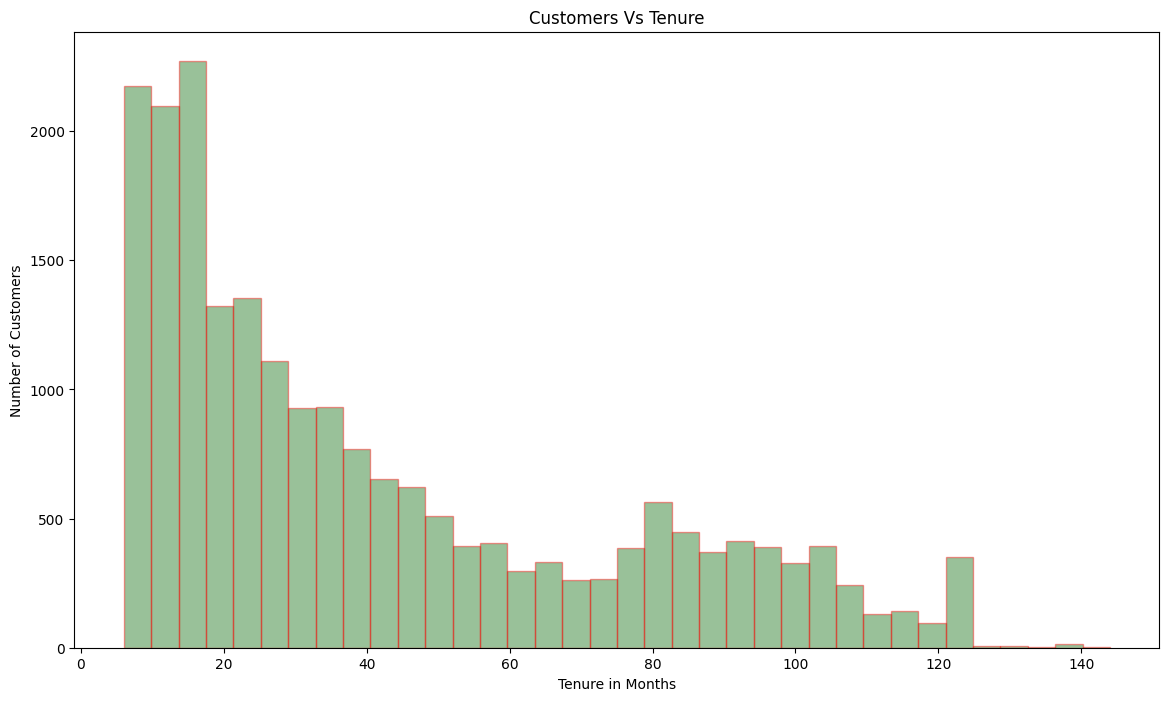

In [488]:
tenure_data = get_tenure_data(telecom_df_high_val_cust)

plot_distplot(tenure_data, 'tenure', 'Tenure in Months', 'Number of Customers', 'Customers Vs Tenure')

In [489]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

12    6-12 Months
15        1-2 Yrs
23        1-2 Yrs
24        2-5 Yrs
27        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

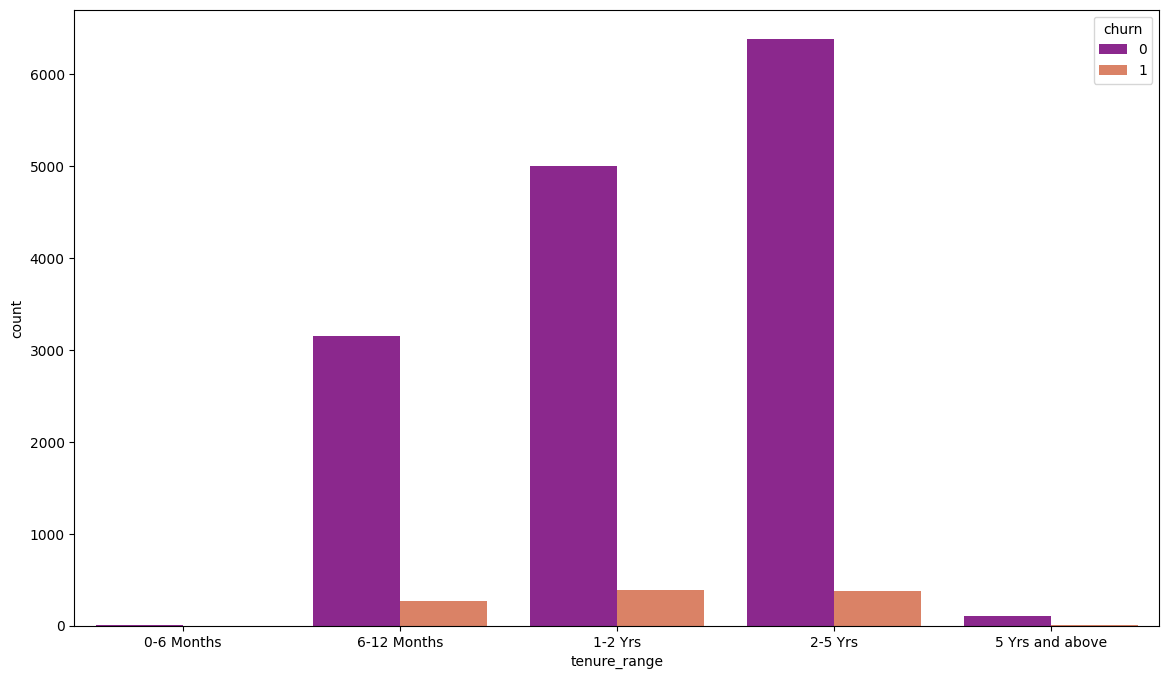

In [490]:
plot_countplot(tenure_data, 'tenure_range', 'churn')

In [491]:
# Checking columns with more than 30% NA values.
rmcols = get_percentage_na_columns_by_threshold(telecom_df_high_val_cust, 30.00)

print("\n The Below Columns will be removed from the Dataset :\n", rmcols)

columns missing value percentage:  {'date_of_last_rech_data_6': 50.443194815097215, 'date_of_last_rech_data_7': 49.4281357224552, 'date_of_last_rech_data_8': 51.72512390392681, 'night_pck_user_6': 50.443194815097215, 'night_pck_user_7': 49.4281357224552, 'night_pck_user_8': 51.72512390392681, 'fb_user_6': 50.443194815097215, 'fb_user_7': 49.4281357224552, 'fb_user_8': 51.72512390392681}

 The Below Columns will be removed from the Dataset :
 ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']


In [492]:
show_df_shape_before_after_drop(telecom_df_high_val_cust, rmcols)

Features before dropping unique values : 134
Dropped columns:  ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']
Features after dropping unique values : 125


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/894478368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


In [493]:
show_df_shape_before_after_drop(telecom_df_high_val_cust, ['max_rech_data_8'])

Features before dropping unique values : 125
Dropped columns:  ['max_rech_data_8']
Features after dropping unique values : 124


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/894478368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


In [494]:
other_cols = filter_columns_by_regex(telecom_df_high_val_cust, '_others_[6-7]')

['og_others_6', 'og_others_7', 'ic_others_6', 'ic_others_7']


In [495]:
impute_null_columns(telecom_df_high_val_cust, other_cols)

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/3652335906.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(np.NaN,0.0)


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn_probability,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
12,12,439.919,397.946,392.024,244.46,108.31,42.98,571.98,727.91,644.43,...,322,0.00,0.00,0.00,0,0.0,0.0,0.0,469.5,0
15,15,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,...,602,0.00,0.00,0.00,0,155.0,0.0,155.0,604.5,0
23,23,1130.948,905.506,479.762,859.53,372.71,0.89,293.46,450.11,386.91,...,455,0.00,0.00,0.00,0,0.0,0.0,0.0,1205.0,0
24,24,371.974,352.069,240.449,93.18,38.29,29.86,531.19,507.76,222.03,...,1219,0.00,0.00,0.00,0,24.0,48.0,24.0,469.5,0
27,27,390.489,350.985,421.300,8.58,11.48,12.68,133.16,158.73,182.83,...,573,700.40,185.71,173.72,0,209.0,306.0,217.0,826.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69982,69982,146.927,458.054,139.068,15.19,33.91,10.06,105.44,166.83,111.54,...,1577,0.00,0.00,0.00,0,0.0,276.0,0.0,449.0,0
69984,69984,1106.130,1609.381,1686.392,84.91,133.44,178.08,823.86,645.89,703.19,...,283,6.48,102.80,127.41,0,452.0,0.0,0.0,1624.0,0
69989,69989,196.695,298.645,192.440,1.05,0.00,5.83,44.74,32.16,30.93,...,251,107.77,112.70,242.18,0,101.0,234.0,92.0,483.5,0
69996,69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,...,879,0.00,0.00,0.00,0,0.0,0.0,0.0,438.0,0


In [496]:
# Checking columns with % NA values.
show_na_percentage(telecom_df_high_val_cust)

ic_others_8            3.678994
og_others_8            3.678994
date_of_last_rech_8    1.906214
date_of_last_rech_7    0.328822
date_of_last_rech_6    0.214449
                         ...   
std_og_t2f_mou_8       0.000000
std_og_t2f_mou_7       0.000000
std_og_t2f_mou_6       0.000000
std_og_t2m_mou_8       0.000000
churn                  0.000000
Length: 124, dtype: float64


In [497]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
telecom_df_high_val_cust.describe(percentiles=[.25, .50, .75, .90, .95, .99])

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn_probability,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
count,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,...,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000
mean,35071.249952,576.428537,576.517390,522.978855,277.564451,284.260783,248.367299,396.159853,397.988602,352.174643,...,1243.255099,163.650055,170.874586,154.590163,0.083683,122.773028,131.361969,115.492048,808.601405,0.054661
min,12.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,433.000000,0.000000
25%,17721.000000,344.073500,345.413000,265.081500,26.010000,25.140000,16.460000,98.102500,94.970000,66.340000,...,470.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,525.000000,0.000000
50%,35118.500000,490.810000,488.007000,442.874000,102.105000,99.810000,79.095000,252.220000,246.925000,209.680000,...,888.500000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,659.500000,0.000000
75%,52346.500000,703.167000,698.986500,663.659500,317.267500,318.390000,262.565000,511.917500,516.382500,458.305000,...,1860.250000,106.907500,106.025000,74.397500,0.000000,199.000000,199.000000,180.000000,916.000000,0.000000
90%,62913.700000,997.110800,990.510600,973.587900,781.592000,806.100000,688.836000,919.799000,931.817000,847.159000,...,2830.000000,572.507000,597.235000,525.390000,0.000000,310.000000,345.000000,306.000000,1281.850000,0.000000
95%,66457.250000,1239.817950,1248.346250,1248.242050,1150.498000,1205.429500,1095.432000,1272.029000,1280.619000,1173.451500,...,3147.000000,923.000500,960.822500,881.618500,1.000000,498.000000,506.000000,492.700000,1631.925000,1.000000
99%,69272.510000,1980.161260,1997.311250,1972.326690,2168.372800,2244.716000,2160.645300,2334.894000,2388.933800,2179.077100,...,3651.000000,1955.066700,2038.184600,1972.403100,1.000000,854.170000,909.000000,900.000000,2588.670000,1.000000
max,69997.000000,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,7043.980000,14007.340000,...,4321.000000,12916.220000,9165.600000,11166.210000,1.000000,5924.000000,4368.000000,4064.000000,37762.500000,1.000000


In [498]:
telecom_df_high_val_cust.dtypes

id                                  int64
arpu_6                            float64
arpu_7                            float64
arpu_8                            float64
onnet_mou_6                       float64
                                   ...   
total_rech_amt_data_6             float64
total_rech_amt_data_7             float64
total_rech_amt_data_8             float64
total_avg_rech_amnt_6_7_GPhase    float64
churn                               int64
Length: 124, dtype: object

In [499]:
numerical_cols = list(telecom_df_high_val_cust.select_dtypes(include=['number']))
numerical_cols

['id',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mo

### Derive new features.

In [500]:
date_columns = get_filtered_columns_by_regex(telecom_df_high_val_cust, 'date_')

drop_cols(telecom_df_high_val_cust, date_columns)

Dropped columns:  ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/894478368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


In [501]:
telecom_df_final = telecom_df_high_val_cust.copy()
print(telecom_df_final.shape)
telecom_df_final.head()

(20984, 121)


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn_probability,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
12,12,439.919,397.946,392.024,244.46,108.31,42.98,571.98,727.91,644.43,...,322,0.0,0.00,0.00,0,0.0,0.0,0.0,469.5,0
15,15,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,...,602,0.0,0.00,0.00,0,155.0,0.0,155.0,604.5,0
23,23,1130.948,905.506,479.762,859.53,372.71,0.89,293.46,450.11,386.91,...,455,0.0,0.00,0.00,0,0.0,0.0,0.0,1205.0,0
24,24,371.974,352.069,240.449,93.18,38.29,29.86,531.19,507.76,222.03,...,1219,0.0,0.00,0.00,0,24.0,48.0,24.0,469.5,0
27,27,390.489,350.985,421.300,8.58,11.48,12.68,133.16,158.73,182.83,...,573,700.4,185.71,173.72,0,209.0,306.0,217.0,826.0,0


In [502]:
drop_cols(telecom_df_final, ['total_avg_rech_amnt_6_7_GPhase'])

Dropped columns:  ['total_avg_rech_amnt_6_7_GPhase']


In [503]:
def add_col_avg_to_df(df, col_list):
    for idx, col in enumerate(col_list.unique()):
        try:
            avg_col_name = "avg_"+col+"_av67"
            col_6 = col+"_6"
            col_7 = col+"_7"
            df[avg_col_name] = (df[col_6]  + df[col_7])/ 2
        except Exception as e:
            print("Error with column merging: \n", col)
            print(e)
            continue
    return df

In [504]:
_6_7_cols = get_filtered_columns_by_regex(telecom_df_final, '_6|_7')

telecom_df_final = add_col_avg_to_df(telecom_df_final, _6_7_cols.str[:-2])

In [505]:
drop_cols(telecom_df_final, _6_7_cols)
print (telecom_df_final.shape)

Dropped columns:  ['arpu_6', 'arpu_7', 'onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'isd_og_mou_6', 'isd_og_mou_7', 'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6', 'og_others_7', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'spl_ic_mou_6', 'spl_ic_mou_7', 'isd_ic_mou_6', 'isd_ic_mou_7', 'ic_others_6', 'ic_others_7', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_amt_6', 'total_rech_amt_7', 'max_rech_amt_6', 'max_rech_amt_7', 'last_d

In [506]:
telecom_df_final.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
12,12,392.024,42.98,644.43,0.0,0.0,3.98,51.24,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
15,15,338.286,194.43,197.09,0.0,0.0,194.43,185.88,4.94,0.00,...,77.0,77.0,130.21,0.00,0.5,0.0,0.0,0.0,0.000,77.5
23,23,479.762,0.89,386.91,0.0,0.0,0.89,378.01,8.88,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
24,24,240.449,29.86,222.03,0.0,0.0,29.86,99.86,0.00,0.36,...,23.0,34.5,0.02,0.00,0.0,1.5,0.0,0.0,0.000,36.0
27,27,421.300,12.68,182.83,0.0,0.0,12.68,157.23,25.59,0.00,...,153.0,254.5,49.46,325.04,0.5,2.0,0.0,0.5,179.715,257.5


In [507]:
telecom_df_final.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'churn_probability',
       'total_rech_amt_data_8', 'churn', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_lo

Observations : We have merged most of the columns related to month 6 & 7 so to reduce the number of features. By doing this apporach we have reduced the fetures from 124 to 84.


### Training the model

In [508]:
def split_date(df):
    Y = df["churn"]
    X = df.drop(["churn"],axis=1)
    return X,Y
    
def scale_data(X):
    scaler = StandardScaler()
    X_col = X.columns
    X_scaled = scaler.fit_transform(X)
    X_scale_final = pd.DataFrame(X_scaled, columns=X_col)
    print("Scaling the data ....")
    return X_scale_final

def get_scree_plot(X):
    pca = PCA(svd_solver='randomized', random_state=101)
    pca.fit(X)
    fig = plt.figure(figsize = (8,6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    return pca

In [509]:
telecom_pca_df = telecom_df_final.copy()
telecom_pca_df.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
12,12,392.024,42.98,644.43,0.0,0.0,3.98,51.24,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
15,15,338.286,194.43,197.09,0.0,0.0,194.43,185.88,4.94,0.00,...,77.0,77.0,130.21,0.00,0.5,0.0,0.0,0.0,0.000,77.5
23,23,479.762,0.89,386.91,0.0,0.0,0.89,378.01,8.88,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
24,24,240.449,29.86,222.03,0.0,0.0,29.86,99.86,0.00,0.36,...,23.0,34.5,0.02,0.00,0.0,1.5,0.0,0.0,0.000,36.0
27,27,421.300,12.68,182.83,0.0,0.0,12.68,157.23,25.59,0.00,...,153.0,254.5,49.46,325.04,0.5,2.0,0.0,0.5,179.715,257.5


In [510]:
telecom_pca_df.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'churn_probability',
       'total_rech_amt_data_8', 'churn', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_lo

In [511]:
#Splitting in x and y
X,Y=split_date(telecom_pca_df)

In [512]:
X.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
12,12,392.024,42.98,644.43,0.0,0.0,3.98,51.24,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
15,15,338.286,194.43,197.09,0.0,0.0,194.43,185.88,4.94,0.00,...,77.0,77.0,130.21,0.00,0.5,0.0,0.0,0.0,0.000,77.5
23,23,479.762,0.89,386.91,0.0,0.0,0.89,378.01,8.88,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
24,24,240.449,29.86,222.03,0.0,0.0,29.86,99.86,0.00,0.36,...,23.0,34.5,0.02,0.00,0.0,1.5,0.0,0.0,0.000,36.0
27,27,421.300,12.68,182.83,0.0,0.0,12.68,157.23,25.59,0.00,...,153.0,254.5,49.46,325.04,0.5,2.0,0.0,0.5,179.715,257.5


In [513]:
Y.head(10)

12    0
15    0
23    0
24    0
27    0
33    0
39    0
45    0
49    0
52    0
Name: churn, dtype: int64

In [514]:
print("Percenatge of Churned Customer data : "+str(round(100*Y.sum()/len(Y),2)))

Percenatge of Churned Customer data : 5.47


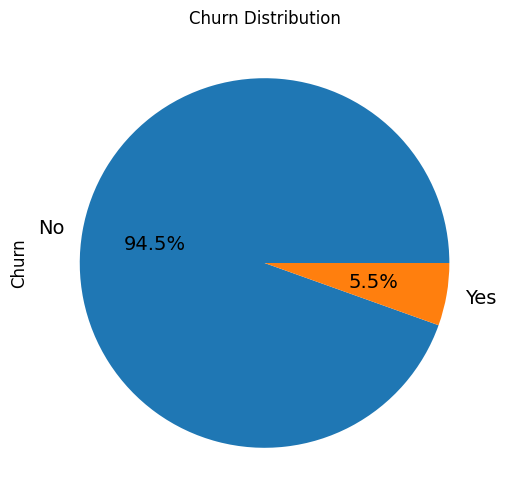

In [515]:
plot_pie_chart(telecom_pca_df, 'churn', 'Churn', 'Churn Distribution')

### Scaling the data to normalize all the fields

In [516]:
X_scaled = scale_data(X)
print(X_scaled.shape)
X_scaled.head(5)

Scaling the data ....
(20984, 80)


,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,-1.741335,-0.254323,-0.437773,0.614531,-0.167619,-0.190201,-0.328977,-0.463071,-0.319299,-0.235883,...,-0.734751,-0.679548,-0.376848,-0.401420,-0.463536,-0.368311,-0.393106,-0.207546,-0.413242,-0.682782
1,-1.741186,-0.358685,-0.114965,-0.326099,-0.167619,-0.190201,0.476813,0.126022,-0.065164,-0.235883,...,-0.000637,-0.263219,0.068408,-0.401420,0.820536,-0.368311,-0.393106,-0.207546,-0.413242,-0.266345
2,-1.740788,-0.083930,-0.527486,0.073039,-0.167619,-0.190201,-0.342050,0.966652,0.137527,-0.235883,...,-0.734751,-0.679548,-0.376848,-0.401420,-0.463536,-0.368311,-0.393106,-0.207546,-0.413242,-0.682782
3,-1.740739,-0.548691,-0.465738,-0.273658,-0.167619,-0.190201,-0.219479,-0.250343,-0.319299,-0.184745,...,-0.515470,-0.493011,-0.376780,-0.401420,-0.463536,0.329829,-0.393106,-0.207546,-0.413242,-0.489341
4,-1.740590,-0.197467,-0.502356,-0.356084,-0.167619,-0.190201,-0.292167,0.000669,0.997164,-0.235883,...,0.723943,0.696500,-0.207719,-0.024537,0.820536,0.562542,-0.393106,0.332660,0.043126,0.700864


In [517]:
#replacing nan with 0
X_scaled=impute_null_columns(X_scaled, None)

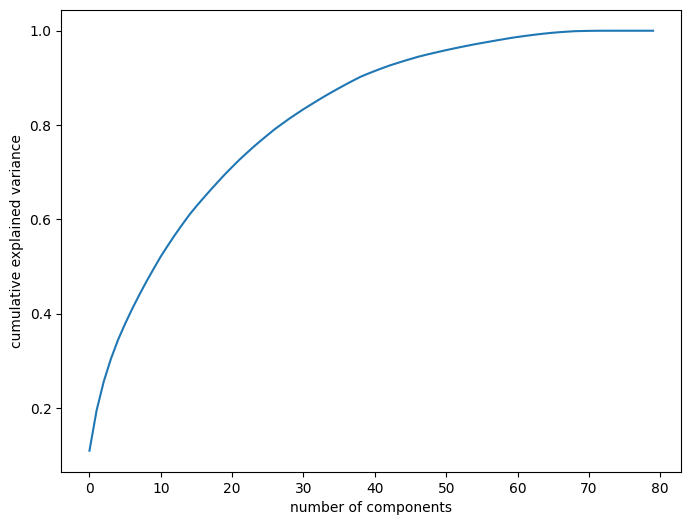

,PC1,PC2,PC3,Feature
0,0.003295,0.003640,-0.005005,id
1,0.049261,0.319631,0.113330,arpu_8
2,-0.082087,0.138639,0.149792,onnet_mou_8
3,-0.067617,0.229695,0.075803,offnet_mou_8
4,0.000553,0.043895,0.004392,roam_ic_mou_8


In [518]:
pca = get_scree_plot(X_scaled) # scree plot

col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head()

In [519]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.93,  19.47,  25.59,  30.38,  34.42,  37.86,  41.04,  44.02,
        46.85,  49.52,  52.13,  54.47,  56.74,  58.88,  60.96,  62.81,
        64.55,  66.27,  67.93,  69.57,  71.1 ,  72.61,  74.  ,  75.37,
        76.67,  77.92,  79.15,  80.25,  81.34,  82.36,  83.35,  84.29,
        85.22,  86.13,  87.  ,  87.85,  88.67,  89.47,  90.24,  90.88,
        91.48,  92.05,  92.6 ,  93.09,  93.57,  94.02,  94.46,  94.85,
        95.21,  95.56,  95.91,  96.23,  96.54,  96.84,  97.14,  97.41,
        97.68,  97.95,  98.21,  98.47,  98.7 ,  98.9 ,  99.1 ,  99.28,
        99.45,  99.6 ,  99.72,  99.82,  99.92,  99.96, 100.  , 100.02,
       100.03, 100.03, 100.03, 100.03, 100.03, 100.03, 100.03, 100.03])

Observation : Looks like 60 components are enough to describe 95% of the variance in the dataset.We'll choose 60 components for our modeling


### Model Prediction and Evaluation

In [520]:
test_data=pd.read_csv("telecom-churn-case-study-hackathon-c-63/test.csv")

In [521]:
test_data.shape

(30000, 171)

In [522]:
telecom_pca_df.shape

(20984, 81)

In [523]:
telecom_pca_df.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'churn_probability',
       'total_rech_amt_data_8', 'churn', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_lo

In [524]:
x_train=X
y_train=Y

In [525]:
X.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'churn_probability',
       'total_rech_amt_data_8', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_loc_og_t2f_

In [526]:
test_data = impute_null_columns(test_data,recharge_columns)

In [527]:
# adding new column total recharge amount for data: total_rech_amt_data for calculating High Value customer process
test_data = add_total_rech_amt_data(test_data)

In [528]:
test_data = add_avg_rech_amt_good_phase(test_data, rc_cols)

In [529]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 175 entries, id to total_avg_rech_amnt_6_7_GPhase
dtypes: float64(139), int64(27), object(9)
memory usage: 40.1+ MB


In [530]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = create_quantile_filter_by_threshold(test_data, "total_avg_rech_amnt_6_7_GPhase", 0.7)
test_data_high_val_cust = test_data

In [531]:
drop_col_with_unique_col_map = get_drop_col_with_unique_col(test_data_high_val_cust)

{'circle_id': 1, 'loc_og_t2o_mou': 2, 'std_og_t2o_mou': 2, 'loc_ic_t2o_mou': 2, 'last_date_of_month_6': 1, 'last_date_of_month_7': 2, 'last_date_of_month_8': 2, 'std_og_t2c_mou_6': 2, 'std_og_t2c_mou_7': 2, 'std_og_t2c_mou_8': 2, 'std_ic_t2o_mou_6': 2, 'std_ic_t2o_mou_7': 2, 'std_ic_t2o_mou_8': 2}


In [532]:
show_df_shape_before_after_drop(test_data_high_val_cust, list(drop_col_with_unique_col_map.keys()))

Features before dropping unique values : 175
Dropped columns:  ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']
Features after dropping unique values : 162


In [533]:
test_data_high_val_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 162 entries, id to total_avg_rech_amnt_6_7_GPhase
dtypes: float64(130), int64(26), object(6)
memory usage: 37.1+ MB


In [534]:
test_data_high_val_cust = convert_to_datetime(test_data_high_val_cust, date_cols)
test_data_high_val_cust.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,...,NaN,NaN,1692,0.00,0.00,0.00,0.0,0.0,0.0,96.5
1,70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,...,NaN,NaN,2533,0.00,0.00,0.00,0.0,0.0,0.0,500.0
2,70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,...,NaN,NaN,277,525.61,758.41,241.84,0.0,0.0,0.0,750.0
3,70002,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,...,NaN,NaN,1244,0.00,0.00,0.00,0.0,0.0,0.0,185.0
4,70003,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,...,NaN,NaN,462,0.00,0.00,0.00,0.0,0.0,0.0,423.0


In [535]:
#Getting the last day recharge amount columns
last_day_rech_amt = filter_columns_by_regex(test_data_high_val_cust, 'day')

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']


In [536]:
usage_2g_and_3g = filter_columns_by_regex(test_data_high_val_cust, '2g|3g')

['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']


In [537]:
# check Volume based cost 
vbc_column = filter_columns_by_regex(test_data_high_val_cust, 'vbc_')

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']


In [538]:
# Renaming month named vbc columns to 6,7,8,9 format
test_data_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'}, inplace=True)

vbc_column = filter_columns_by_regex(test_data_high_val_cust, 'vbc_3g')

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']


In [539]:
# Checking Service schemes with validity smaller than a month for 2G/3G
SC_2g_or_3g_col = filter_columns_by_regex(test_data_high_val_cust, 'sachet_2g|sachet_3g')

['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


In [540]:
# Checking columns for average revenue per user
arpu_cols = filter_columns_by_regex(test_data_high_val_cust, 'arpu_')

['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']


In [541]:
mou_cols = filter_columns_by_regex(test_data_high_val_cust, 'mou')

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6'

In [542]:
impute_null_columns(test_data, mou_cols.to_list())

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,...,NaN,NaN,1692,0.00,0.00,0.00,0.0,0.0,0.0,96.5
1,70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,...,NaN,NaN,2533,0.00,0.00,0.00,0.0,0.0,0.0,500.0
2,70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,...,NaN,NaN,277,525.61,758.41,241.84,0.0,0.0,0.0,750.0
3,70002,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,...,NaN,NaN,1244,0.00,0.00,0.00,0.0,0.0,0.0,185.0
4,70003,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,...,NaN,NaN,462,0.00,0.00,0.00,0.0,0.0,0.0,423.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,99994,718.870,396.259,406.150,324.46,250.01,285.41,190.36,166.14,221.96,...,NaN,NaN,1255,3.71,105.64,61.48,126.0,0.0,0.0,677.0
29996,99995,218.327,324.070,374.981,263.79,467.24,650.26,108.53,124.11,189.76,...,0.0,NaN,2258,0.00,0.00,0.00,0.0,178.0,0.0,396.5
29997,99996,139.473,38.230,180.194,11.08,14.89,19.94,37.24,16.74,45.28,...,NaN,NaN,440,0.00,0.00,0.00,0.0,0.0,0.0,75.0
29998,99997,1122.912,781.121,257.439,122.74,50.23,26.46,1854.09,1088.83,306.16,...,NaN,NaN,810,0.00,0.00,0.00,0.0,0.0,0.0,1081.0


In [543]:
mou_og_cols6 = filter_columns_by_regex(test_data_high_val_cust, '.*_og_.*mou_6')

['roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'total_og_mou_6']


In [544]:
list_total_og_cols = filter_columns_by_regex(test_data_high_val_cust, 'total_og_mou|std_og_mou|loc_og_mou')

['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']


In [545]:
drop_cols(test_data_high_val_cust, list_total_og_cols)

Dropped columns:  ['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']


In [546]:
mou_ic_cols6 = filter_columns_by_regex(test_data_high_val_cust, '.*_ic_.*mou_6')

['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6']


In [547]:
list_total_ic_cols = filter_columns_by_regex(test_data_high_val_cust, 'total_ic_mou|std_ic_mou|loc_ic_mou')

['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


In [548]:
drop_cols(test_data_high_val_cust, list_total_ic_cols)

Dropped columns:  ['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


In [549]:
offnet_usage_service_col = filter_columns_by_regex(test_data_high_val_cust, 'offnet.*mou')

['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']


In [550]:
onnet_usage_service = filter_columns_by_regex(test_data_high_val_cust, '^onnet.*mou')

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']


In [551]:
test_data_high_val_cust.shape

(30000, 144)

In [552]:
tenure_data = get_tenure_data(test_data_high_val_cust)

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_99981/1760500538.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[col], hist=True, kde=False,


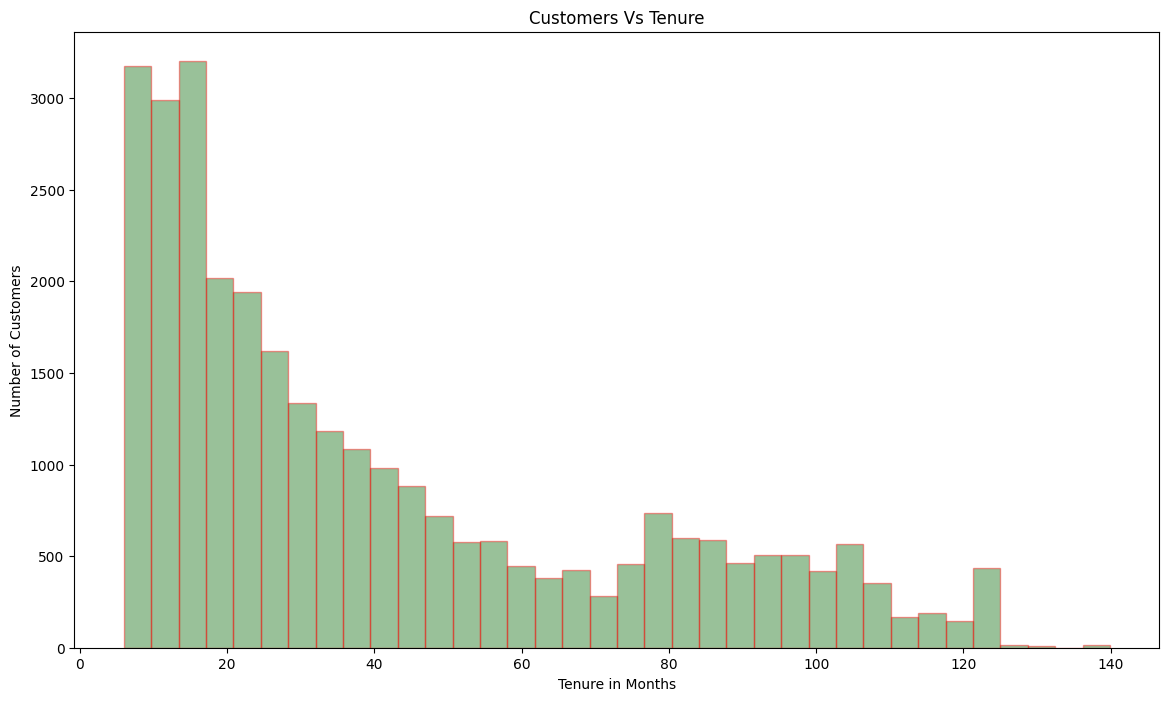

In [553]:
plot_distplot(tenure_data, 'tenure', 'Tenure in Months', 'Number of Customers', 'Customers Vs Tenure')

In [554]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

0        2-5 Yrs
1            NaN
2    6-12 Months
3        2-5 Yrs
4        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

In [555]:
test_data_final = test_data_high_val_cust.copy()
print(test_data_final.shape)
test_data_final.head(3)

(30000, 144)


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,...,NaN,NaN,1692,0.00,0.00,0.00,0.0,0.0,0.0,96.5
1,70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,...,NaN,NaN,2533,0.00,0.00,0.00,0.0,0.0,0.0,500.0
2,70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,...,NaN,NaN,277,525.61,758.41,241.84,0.0,0.0,0.0,750.0


In [556]:
drop_cols(test_data_final, ["total_avg_rech_amnt_6_7_GPhase"])

Dropped columns:  ['total_avg_rech_amnt_6_7_GPhase']


In [557]:
test_date_columns = get_filtered_columns_by_regex(test_data_high_val_cust, 'date_')
drop_cols(test_data_final, test_date_columns)

Dropped columns:  ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']


In [558]:
print (test_data_final.shape)

(30000, 137)


In [559]:
test_6_7_cols = get_filtered_columns_by_regex(test_data_final, '_6|_7')

test_data_final = add_col_avg_to_df(test_data_final, _6_7_cols.str[:-2])

In [560]:
test_data_final.columns.to_list()

['id',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mo

In [561]:
test_cols = ['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8',
       'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8',
       'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon',
       'vbc_3g_8', 'total_rech_amt_data_8',
       'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67',
       'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_loc_og_t2f_mou_av67', 'avg_loc_og_t2c_mou_av67',
       'avg_std_og_t2t_mou_av67', 'avg_std_og_t2m_mou_av67',
       'avg_std_og_t2f_mou_av67', 'avg_isd_og_mou_av67', 'avg_spl_og_mou_av67',
       'avg_og_others_av67', 'avg_loc_ic_t2t_mou_av67',
       'avg_loc_ic_t2m_mou_av67', 'avg_loc_ic_t2f_mou_av67',
       'avg_std_ic_t2t_mou_av67', 'avg_std_ic_t2m_mou_av67',
       'avg_std_ic_t2f_mou_av67', 'avg_spl_ic_mou_av67', 'avg_isd_ic_mou_av67',
       'avg_ic_others_av67', 'avg_total_rech_num_av67',
       'avg_total_rech_amt_av67', 'avg_max_rech_amt_av67',
       'avg_last_day_rch_amt_av67', 'avg_total_rech_data_av67',
       'avg_max_rech_data_av67', 'avg_av_rech_amt_data_av67',
       'avg_vol_2g_mb_av67', 'avg_vol_3g_mb_av67', 'avg_monthly_2g_av67',
       'avg_sachet_2g_av67', 'avg_monthly_3g_av67', 'avg_sachet_3g_av67',
       'avg_vbc_3g_av67', 'avg_total_rech_amt_data_av67']

test_x=test_data_final[test_cols]

In [562]:
test_x.shape

(30000, 79)

In [563]:
X.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'churn_probability',
       'total_rech_amt_data_8', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_loc_og_t2f_

In [564]:
X = impute_null_columns(X, None)

In [565]:
#prepare test aand train data
x_train=X
y_train=Y

x_test=test_x

In [566]:
x_train.shape

(20984, 80)

In [567]:
x_test.shape

(30000, 79)

In [568]:
X_train=x_train.drop(['churn_probability'],axis=1)

In [569]:
y_train.head()

12    0
15    0
23    0
24    0
27    0
Name: churn, dtype: int64

In [570]:
y_train.shape

(20984,)

### Tree Model Regression

In [571]:
telecom_tree_df = telecom_df_final.copy()

In [572]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [573]:
x_test=impute_null_columns(x_test, None)

In [574]:
x_test.shape

(30000, 79)

In [575]:
# Making predictions
predictions = rfc.predict(x_test)
predictions

array([0, 0, 1, ..., 0, 0, 0])

### Hyperparameter Tuning


In [576]:
def tune_hyperparameter(parameters,x_train,y_train,n_folds = 5,max_depth=0):
    if(max_depth==0):
        rf = RandomForestClassifier()
    else :
        rf = RandomForestClassifier(max_depth=max_depth)
        
    rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
    rf.fit(x_train, y_train)
    scores = rf.cv_results_

    for key in parameters.keys():
        hyperparameters = key
        break

    # Print the best parameters
    print(f"Best Parameters: {rf.best_params_}")

    # plotting accuracies for parameters
    plot_accuracy(scores, hyperparameters, "training accuracy", "test accuracy")
   

def plot_accuracy(df, hyperparametes, train_accuracy_label, test_accuracy_label):
    plt.figure(figsize=(16,5))
    plt.plot(df["param_"+hyperparametes], df["mean_train_score"], label=train_accuracy_label)
    plt.plot(df["param_"+hyperparametes], df["mean_test_score"], label=test_accuracy_label)
    plt.xlabel(hyperparametes)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### Tuning max_depth

find optimum values for 'max_depth' and understand how the value of max_depth impacts the overall accuracy of the ensemble.

Best Parameters: {'max_depth': 32}


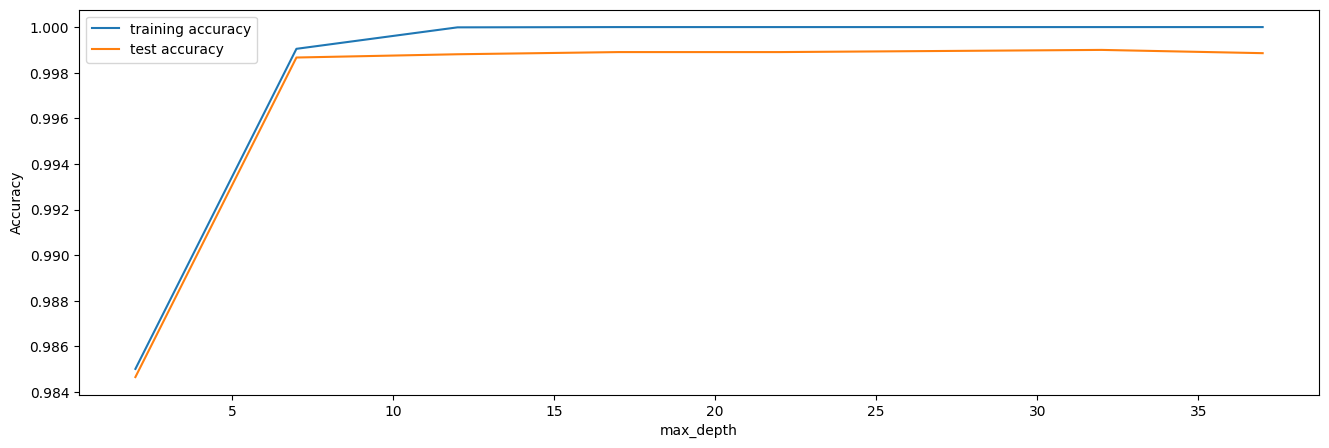

In [577]:
# parameters to build the model on
parameters = {'max_depth': range(2, 40, 5)}
tune_hyperparameter(parameters,x_train,y_train)

#### Observations:
<ol>
<li>We can see that as we increase the value of max_depth, both train and test scores increase till a point, but after that test score becomme stagnant.
<li>The ensemble tries to overfit as we increase the max_depth. Thus, controlling the depth of the constituent trees will help reduce overfitting in the forest.
<li>7 and 12 value have peek convergens and can be used for grid veiw search.
</ol>

### Tuning n_estimators

find the optimum values for n_estimators and understand how the value of n_estimators impacts the overall accuracy.
we'll specify an appropriately low value of max_depth, so that the trees do not overfit.

Best Parameters: {'n_estimators': 900}


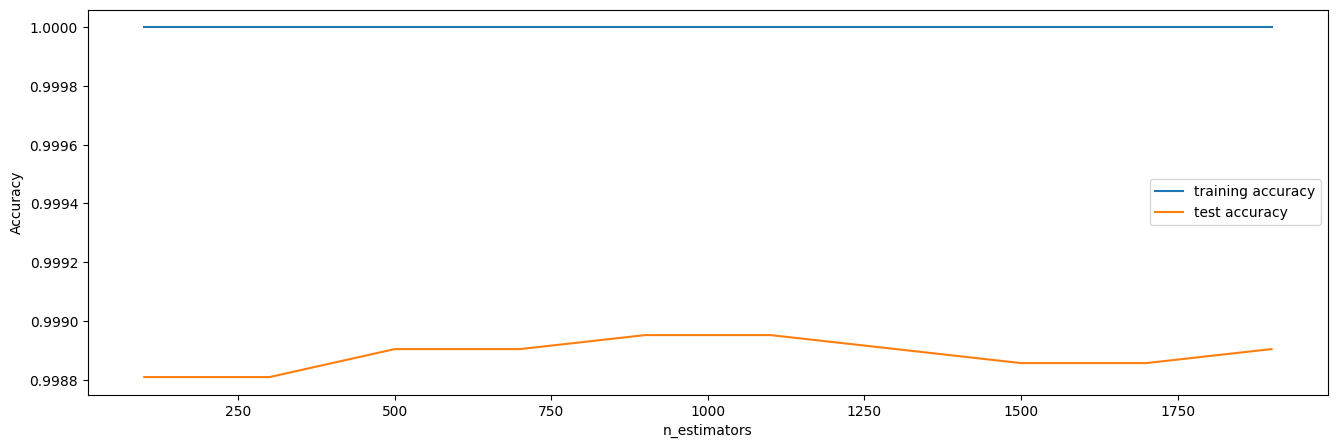

In [578]:
# parameters to build the model on
parameters = {'n_estimators': range(100, 2000, 200)}
tune_hyperparameter(parameters,x_train,y_train)

Observation: Score almost remain the same with very low dip throught the range. We will use 200 for grid view search.

### Tuning max_features

observing model performance varies with 'max_features', which is the maximum numbre of features considered for splitting at a node.

Best Parameters: {'max_features': 30}


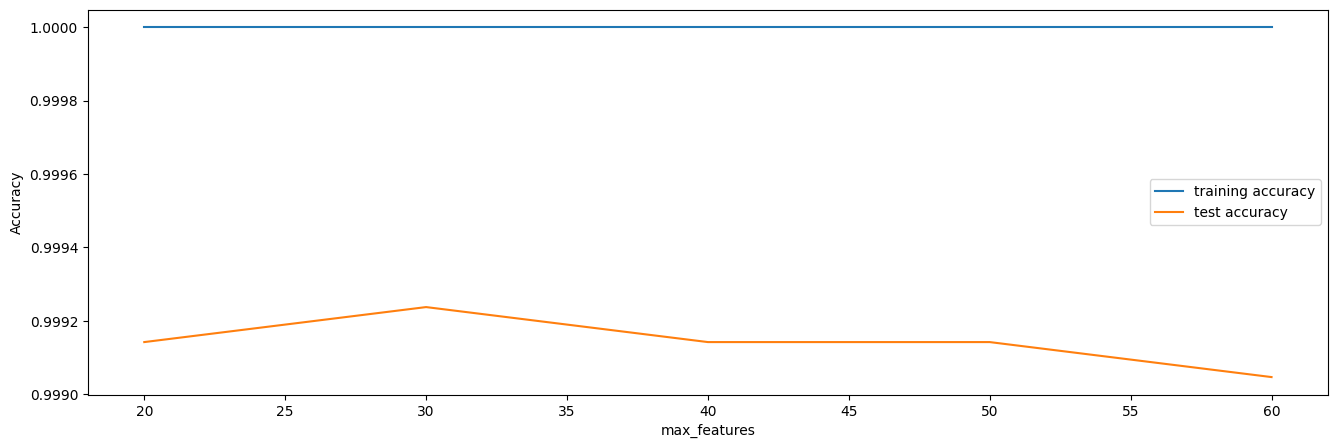

In [579]:
# parameters to build the model on
parameters = {'max_features': [20,30,40,50,60]}
tune_hyperparameter(parameters,x_train,y_train,4)

Observation: Apparently, accuracy of training seems to be stable and test scores seems to increase till 40 and then decrease. Again we see increase on 60 and we will use that.

Best Parameters: {'min_samples_leaf': 1}


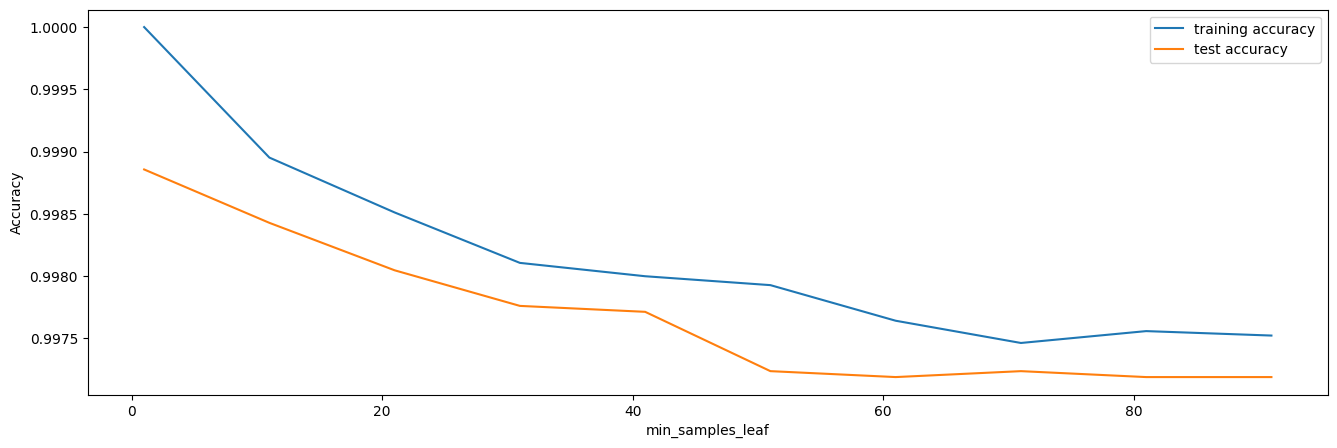

In [580]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(1, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)

Observation: We can see that the model starts to overfit as value is decrease the value of min_samples_leaf. 10 to 20 seems to be a good range and that will be used in grid search.

Best Parameters: {'min_samples_split': 10}


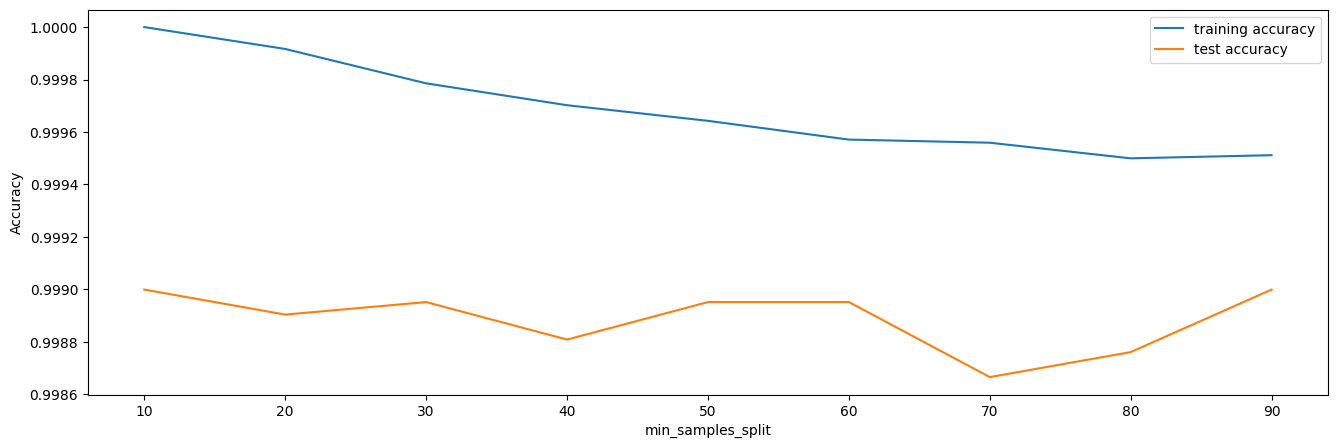

In [581]:
# parameters to build the model on
parameters = {'min_samples_split': range(10, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)

Observation: Range 10 to 30 is optimal with good accuracy.

### Grid Search to Find Optimal Hyperparameters

In [582]:
#We can now find the optimal hyperparameters using GridSearchCV.
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [7,12],
    'n_estimators': [200],
    'max_features': [40],
    'min_samples_leaf': [10,20],
    'min_samples_split': [10,20,30]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,return_train_score=True)

In [583]:
# Fit the grid search to the data
rf_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [7, 12], 'max_features': [40],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [200]},
             return_train_score=True, verbose=1)

In [584]:
#printing the optimal accuracy score and hyperparameters
print('We can get accuracy of '+str(round(rf_grid_search.best_score_,2))+' using '+str(rf_grid_search.best_params_))

We can get accuracy of 1.0 using {'max_depth': 7, 'max_features': 40, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [585]:
print("Max accuracy with Random Forest classifier - "+str(round(rf_grid_search.best_score_,2)))

Max accuracy with Random Forest classifier - 1.0


### Building and Evaluating the Final Model for Random Forest

In [586]:
rfc = RandomForestClassifier(max_depth=12,
                             max_features=40,
                             min_samples_leaf=10,
                             min_samples_split=10,
                             n_estimators=200,
                             n_jobs = -1)
# Train the model
rfc_model = rfc.fit(X_train,y_train)

In [587]:
# Making predictions
predictions = rfc_model.predict(x_test)

In [588]:
solution_data=pd.DataFrame(predictions,index=test_data['id'],columns=['churn_probability'])

In [589]:
# Validating the Accuracy, Recall and Confusion matrix
y_test = solution_data['churn_probability']
print("Accuracy Score: {0}".format(metrics.accuracy_score(y_test, predictions)))
print("Sensitivity/Recall: {0}".format(metrics.recall_score(y_test, predictions)))
metrics.confusion_matrix(y_test, predictions)

Accuracy Score: 1.0
Sensitivity/Recall: 1.0


array([[27485,     0],
       [    0,  2515]])

In [590]:
solution_data

,churn_probability
id,
69999,0
70000,0
70001,1
70002,0
70003,0
...,...
99994,0
99995,0
99996,0


In [591]:
solution_data.to_csv("Submission.csv")

### Recommandations

<ol>
<li>Less number of high value customers are churning but for last 6 month no new high valued cusotmer is onboarded which is concerning and company should concentrate on that aspect.
<li>Customers with less than 4 years of tenure are more likely to churn and company should concentrate more on that segment by rolling out new schems to that group.
<li>Average revenue per user seems to be most important feature in determining churn prediction.
<li>Incoming and Outgoing Calls on romaing for 8th month are strong indicators of churn behaviour.
<li>Local Outgoing calls made to landline, fixedline, mobile and call center provides a strong indicator of churn behaviour.
<li>Better 2G/3G area coverage where 2G/3G services are not good, it's strong indicator of churn behaviour.
</ol>